In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

In [2]:
# 시각화에 사용할 팔레트
plt.style.available

sns.color_palette("pastel")
sns.set(palette='pastel')

In [9]:
# train data 불러오기
df_train = pd.read_csv("../../data/train_heat.csv")
df_train = df_train.iloc[:,1:]
df_train

train_heat.tm train_heat.branch_id  train_heat.ta  train_heat.wd  \
0          2021010101                    A          -10.1           78.3   
1          2021010102                    A          -10.2           71.9   
2          2021010103                    A          -10.0          360.0   
3          2021010104                    A           -9.3          155.9   
4          2021010105                    A           -9.0           74.3   
...               ...                  ...            ...            ...   
499296     2023123119                    S            3.2          233.5   
499297     2023123120                    S            2.9          227.4   
499298     2023123121                    S            2.1          360.0   
499299     2023123122                    S            2.2           30.0   
499300     2023123123                    S            1.2          359.0   

        train_heat.ws  train_heat.rn_day  train_heat.rn_hr1  train_heat.hm  \
0                 0.5                0.0                0.0           68.2   
1                 0.6                0.0                0.0           69.9   
2                 0.0                0.0                0.0           69.2   
3                 0.5                0.0                0.0           65.0   
4                 1.9                0.0                0.0           63.5   
...               ...                ...                ...            ...   
499296            0.4                2.5                0.0           91.5   
499297            0.1                2.5                0.0           92.1   
499298            0.0                2.5                0.0           93.3   
499299            1.4                2.5                0.0           95.5   
499300            0.8                2.5                0.0           94.9   

        train_heat.si  train_heat.ta_chi  train_heat.heat_demand  
0               -99.0               -8.2                     281  
1               -99.0               -8.6                     262  
2               -99.0               -8.8                     266  
3               -99.0               -8.9                     285  
4               -99.0               -9.2                     283  
...               ...                ...                     ...  
499296          -99.0                2.8                      34  
499297          -99.0                2.7                      35  
499298          -99.0                1.4                      35  
499299          -99.0                1.3                      40  
499300          -99.0                0.6                      33  

[499301 rows x 11 columns]

In [10]:
# 변수명 정리
df_train.columns = [col.replace("train_heat.", "") for col in df_train.columns]

In [11]:
# tm 변수 datetime 처리
df_train['tm'] = pd.to_datetime(df_train['tm'].astype(str), format='%Y%m%d%H')

In [12]:
# -99 포함 여부 확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -99.0).any()]
print("'-99.0' 포함 열:", cols_with_neg99)

# -99.0을 np.nan으로 바꾸기
df_train[cols_with_neg99] = df_train[cols_with_neg99].replace(-99.0, np.nan)

# np.nan으로 변경 후, 포함 여부 재확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -99.0).any()]
print("'-99.0' 포함 열:", cols_with_neg99)

'-99.0' 포함 열: ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']
'-99.0' 포함 열: []


In [13]:
# -9.9를 np.nan으로 바꾸기
df_train['wd'] = df_train['wd'].replace(-9.9, np.nan)

# np.nan으로 변경 후, 포함 여부 재확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -9.9).any()]
print("'-9.9' 포함 열:", cols_with_neg99)

'-9.9' 포함 열: ['ta', 'ta_chi']


In [14]:
# 타겟 변수 heat_demand에 결측이 있는 행 제거
df_train = df_train.dropna(subset=['heat_demand']).reset_index(drop=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499278 entries, 0 to 499277
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           499278 non-null  datetime64[ns]
 1   branch_id    499278 non-null  object        
 2   ta           486283 non-null  float64       
 3   wd           478876 non-null  float64       
 4   ws           480465 non-null  float64       
 5   rn_day       480654 non-null  float64       
 6   rn_hr1       480126 non-null  float64       
 7   hm           459567 non-null  float64       
 8   si           266370 non-null  float64       
 9   ta_chi       499258 non-null  float64       
 10  heat_demand  499278 non-null  float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 41.9+ MB


In [15]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [16]:
df_train['year'] = df_train['tm'].dt.year # 연도
df_train['quarter'] = df_train['tm'].dt.quarter # 분기별
df_train['month'] = df_train['tm'].dt.month # 월
df_train['day'] = df_train['tm'].dt.day # 월
df_train['hour'] = df_train['tm'].dt.hour
df_train['day_of_week'] = df_train['tm'].dt.dayofweek # 요일
df_train['season'] = df_train['month'].apply(get_season) # 계절
df_train['is_weekend'] = df_train['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday') # 주말 여부
df_train['weekofyear'] = df_train['tm'].dt.isocalendar().week # 주차

# 3시간 단위 시간대 컬럼 생성 (0~23시 → 0~7로 구간화)
df_train['hour_group'] = (df_train['tm'].dt.hour // 3).astype(int)
hour_labels = ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']

In [17]:
# 공통 규칙 정의

# A,B,C,F
common_night_rules_1 = [
    ((1, 1), (2, 6), 19, 7),
    ((2, 6), (3, 4), 20, 7),
    ((3, 4), (4, 7), 20, 6),
    ((4, 7), (4, 13), 21, 6),
    ((4, 13), (8, 28), 21, 5),
    ((8, 28), (9, 3), 21, 6),
    ((9, 3), (10, 12), 20, 6),
    ((10, 12), (11, 3), 19, 6),
    ((11, 3), (12, 31), 19, 7)
]

# D,E,G,H,I,J,K,S
common_night_rules_2 = [
    ((1, 1), (2, 5), 19, 7),
    ((2, 5), (3, 4), 20, 7),
    ((3, 4), (4, 7), 20, 6),
    ((4, 7), (4, 14), 21, 6),
    ((4, 14), (8, 28), 21, 5),
    ((8, 28), (9, 3), 21, 6),
    ((9, 3), (10, 13), 20, 6),
    ((10, 13), (11, 4), 19, 6),
    ((11, 4), (12, 31), 19, 7)
]

# L,M,N
common_night_rules_3 = [
    ((1, 1), (2, 10), 19, 7),
    ((2, 10), (2, 25), 20, 7),
    ((2, 25), (4, 9), 20, 6),
    ((4, 9), (4, 19), 20, 5),
    ((4, 19), (8, 26), 21, 5),
    ((8, 26), (9, 4), 20, 5),
    ((9, 4), (10, 7), 20, 6),
    ((10, 7), (11, 13), 19, 6),
    ((11, 13), (12, 31), 19, 7)
]

# O
common_night_rules_4 = [
    ((1, 1), (2, 6), 19, 7),
    ((2, 6), (3, 2), 20, 7),
    ((3, 2), (4, 11), 20, 6),
    ((4, 11), (4, 13), 21, 6),
    ((4, 13), (8,30), 21, 5),
    ((8, 30), (9, 1), 21, 6),
    ((9, 1), (10, 11), 20, 6),
    ((10, 11), (11, 7), 19, 6),
    ((11, 7), (12, 31), 19, 7)
]

# P
common_night_rules_5 = [
    ((1, 1), (2, 6), 19, 7),
    ((2, 6), (3, 3), 20, 7),
    ((3, 3), (4, 10), 20, 6),
    ((4, 10), (4, 13), 21, 6),
    ((4, 13), (8,30), 21, 5),
    ((8, 30), (9, 2), 21, 6),
    ((9, 2), (10, 12), 20, 6),
    ((10, 12), (11, 6), 19, 6),
    ((11, 6), (12, 31), 19, 7)
]

# Q
common_night_rules_6 = [
    ((1, 1), (2, 5), 19, 7),
    ((2, 5), (3, 5), 20, 7),
    ((3, 5), (4, 7), 20, 6),
    ((4, 7), (4, 14), 21, 6),
    ((4, 14), (8, 28), 21, 5),
    ((8, 28), (9, 3), 21, 6),
    ((9, 3), (10, 13), 20, 6),
    ((10, 13), (11, 2), 19, 6),
    ((11, 2), (12, 31), 19, 7)
]

# R
common_night_rules_7 = [
    ((1, 1), (2, 1), 19, 7),
    ((2, 1), (3, 2), 20, 7),
    ((3, 2), (4, 9), 20, 6),
    ((4, 9), (4, 15), 21, 6),
    ((4, 15), (8, 26), 21, 5),
    ((8, 26), (9, 2), 21, 6),
    ((9, 2), (10, 14), 20, 6),
    ((10, 14), (11, 8), 19, 6),
    ((11, 8), (12, 31), 19, 7)
]


# 브랜치별 야간 시간 규칙 딕셔너리
branch_night_rules = {
    'A': common_night_rules_1,
    'B': common_night_rules_1,
    'C': common_night_rules_1,
    'D': common_night_rules_2,
    'E': common_night_rules_2,
    'F': common_night_rules_1,
    'G': common_night_rules_2,
    'H': common_night_rules_2,
    'I': common_night_rules_2,
    'J': common_night_rules_2,
    'K': common_night_rules_2,
    'L': common_night_rules_3,
    'M': common_night_rules_3,
    'N': common_night_rules_3,
    'O': common_night_rules_4,
    'P': common_night_rules_5,
    'Q': common_night_rules_6,
    'R': common_night_rules_7,
    'S': common_night_rules_2
}


In [18]:
# 모든 브랜치에 대해 야간 시간 적용
for branch, rules in branch_night_rules.items():
    is_branch = df_train['branch_id'] == branch

    for (start_m, start_d), (end_m, end_d), night_start, night_end in rules:
        in_period = (
            ((df_train['month'] > start_m) | ((df_train['month'] == start_m) & (df_train['day'] >= start_d))) &
            ((df_train['month'] < end_m) | ((df_train['month'] == end_m) & (df_train['day'] <= end_d)))
        )

        if night_start > night_end:  # 자정을 넘기는 경우
            in_night = (df_train['hour'] >= night_start) | (df_train['hour'] <= night_end)
        else:
            in_night = (df_train['hour'] >= night_start) & (df_train['hour'] < night_end)

        # 조건에 맞는 행에 대해 si 값 0으로 설정
        mask = is_branch & in_period & in_night
        df_train.loc[mask, 'si'] = 0

In [19]:
# 결측치 확인
missing_df = pd.DataFrame({
    'Missing Count': df_train.isnull().sum(),
    'Missing Ratio (%)': df_train.isnull().mean() * 100
})

# 결측치가 있는 열만 추출
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)
print(missing_df)

        Missing Count  Missing Ratio (%)
hm              39711           7.953685
wd              20402           4.086301
rn_hr1          19152           3.835939
ws              18813           3.768041
rn_day          18624           3.730186
ta              12995           2.602758
si              10347           2.072393
ta_chi             20           0.004006


In [20]:
# 풍향 sin, cos 변환
df_train['wd_rad'] = np.deg2rad(df_train['wd'])  # 도 → 라디안 변환
df_train['wd_sin'] = np.sin(df_train['wd_rad'])
df_train['wd_cos'] = np.cos(df_train['wd_rad'])

In [21]:
cluster2_branch_ids = ['A','D','H','P']
df_train_cluster2 = df_train[df_train['branch_id'].isin(cluster2_branch_ids)]

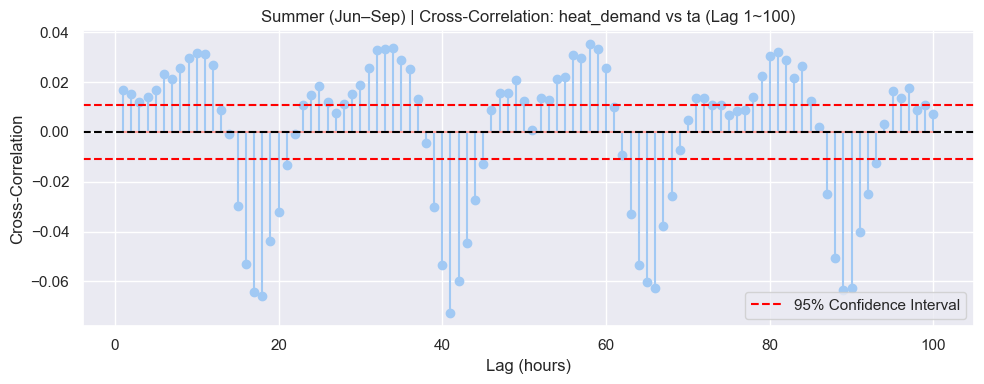

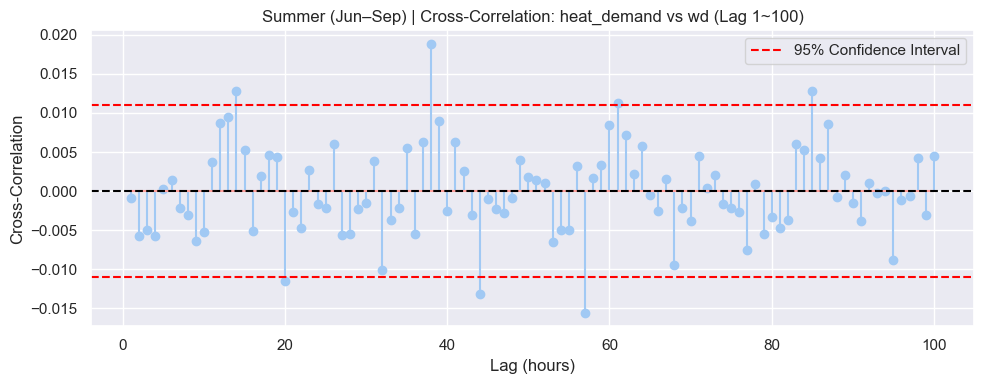

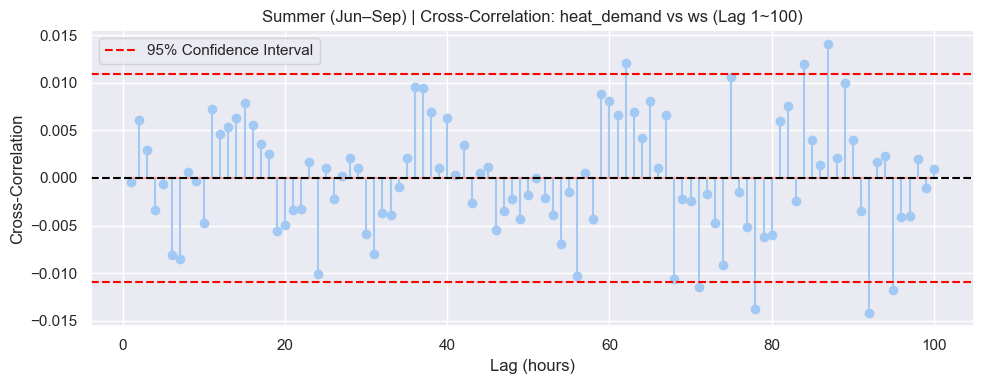

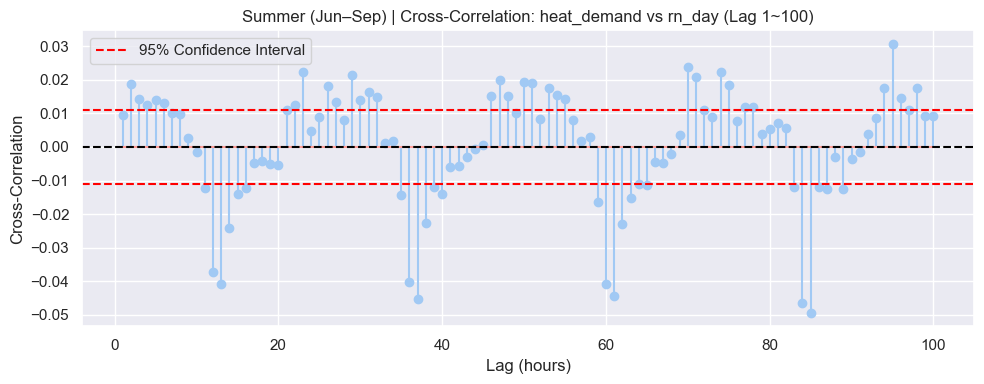

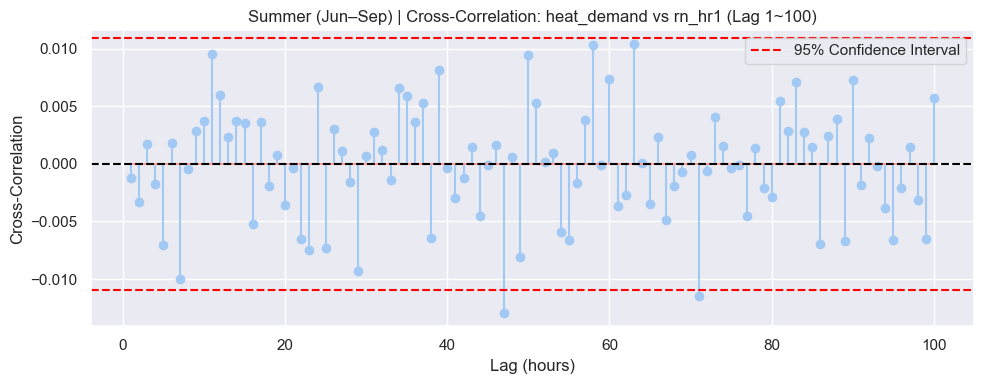

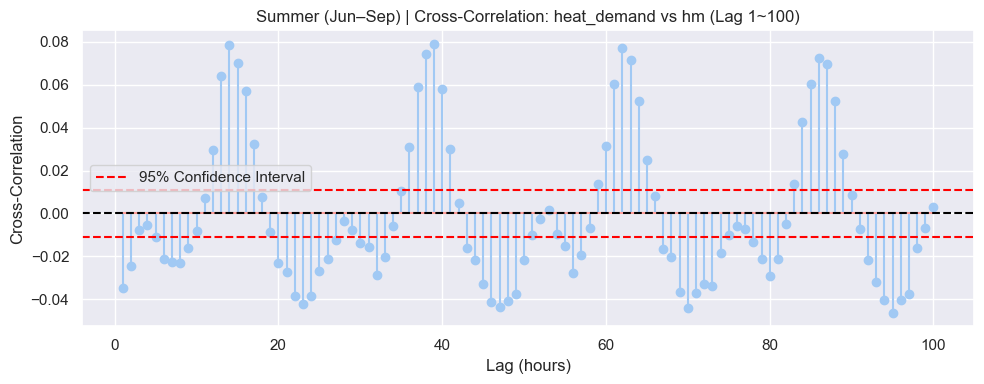

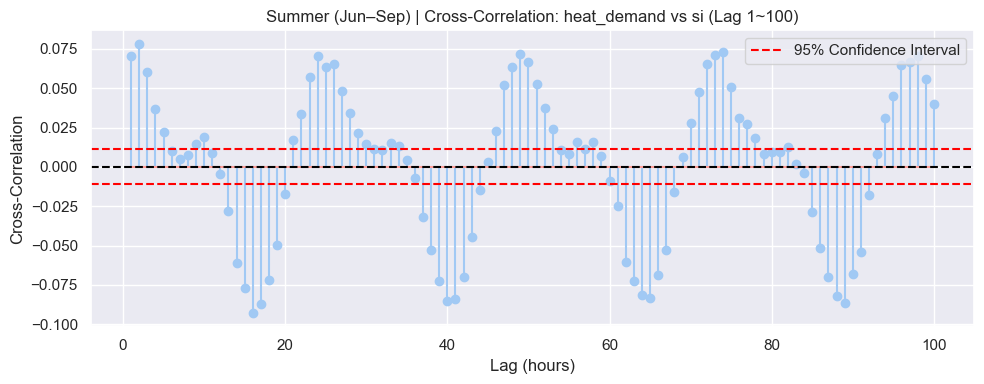

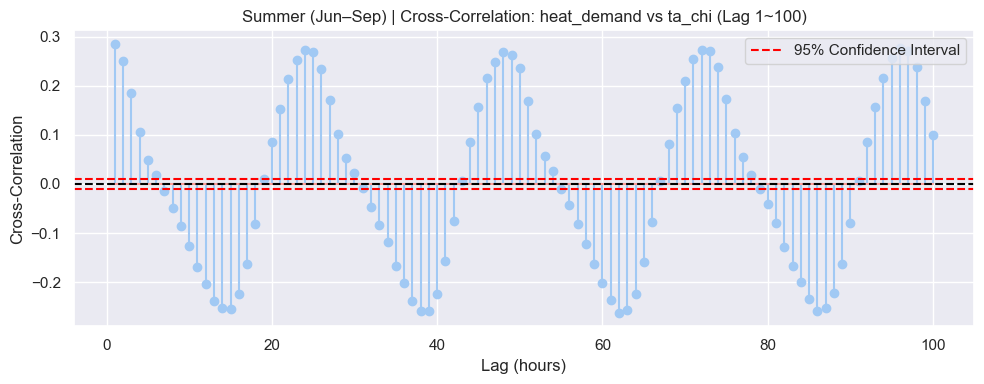

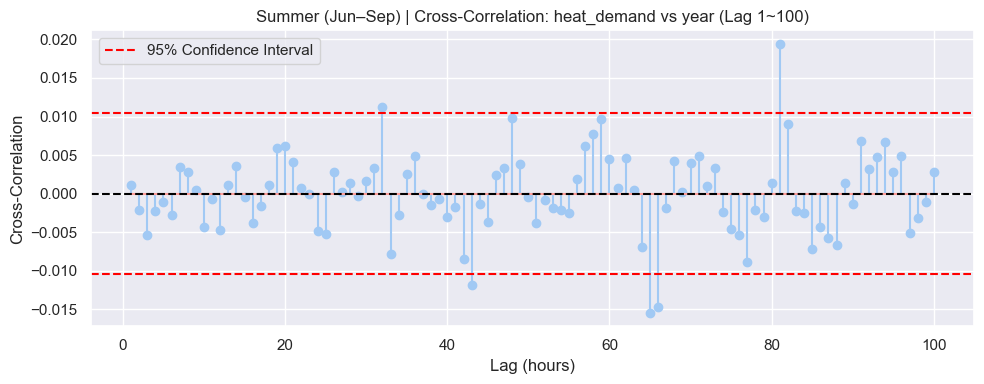

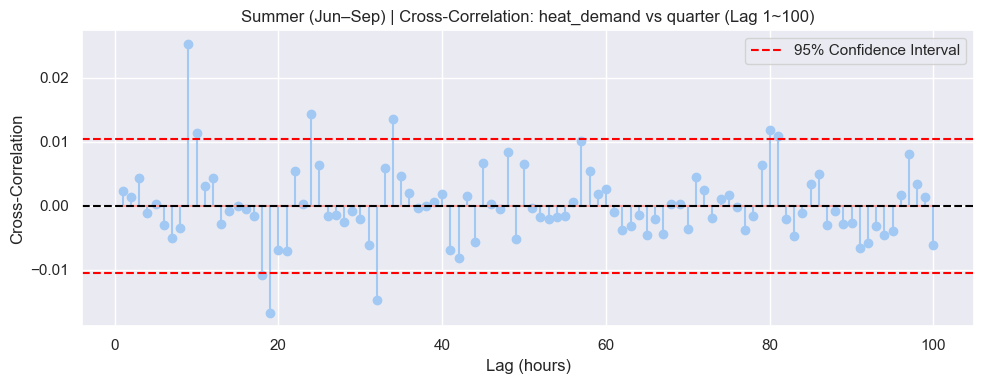

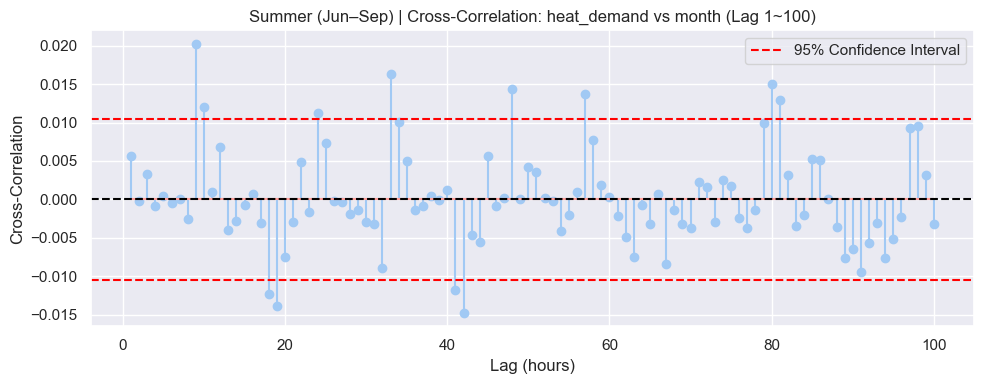

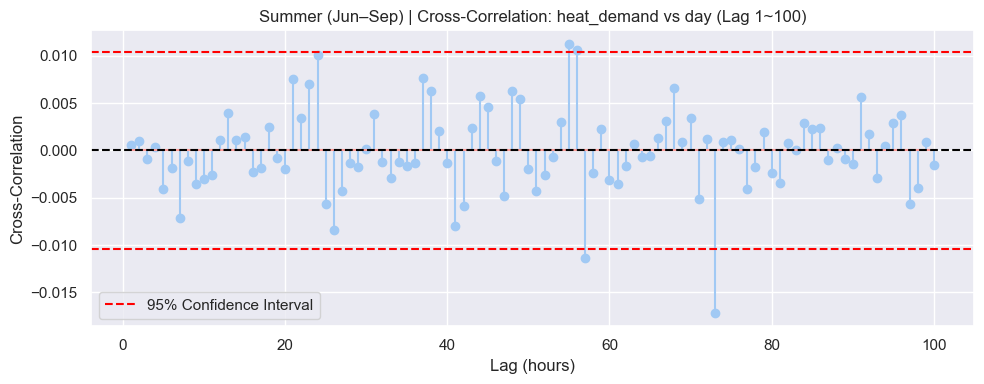

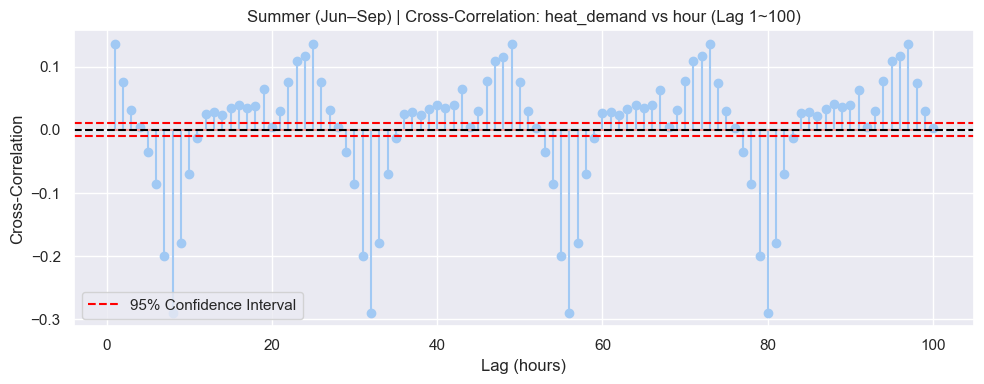

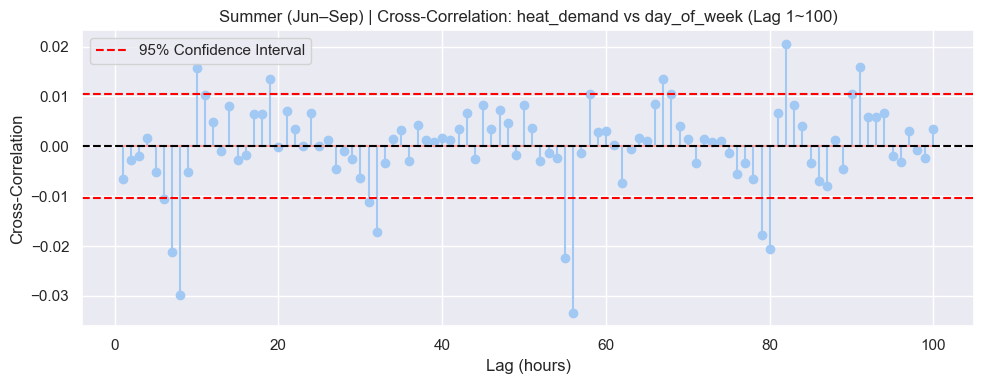

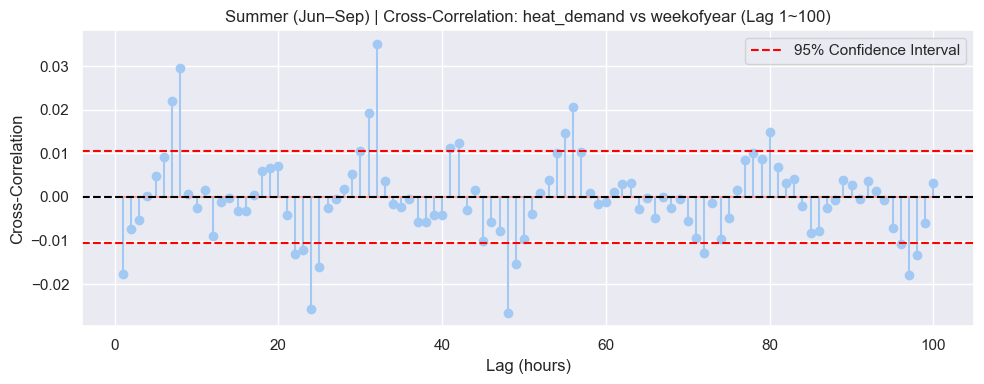

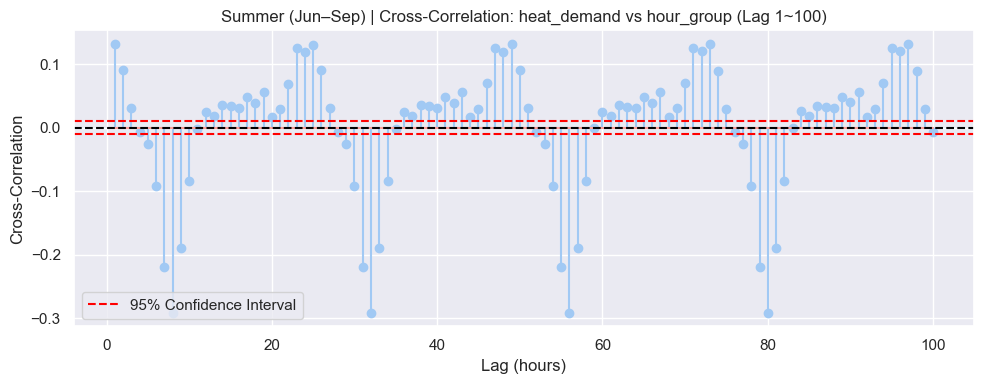

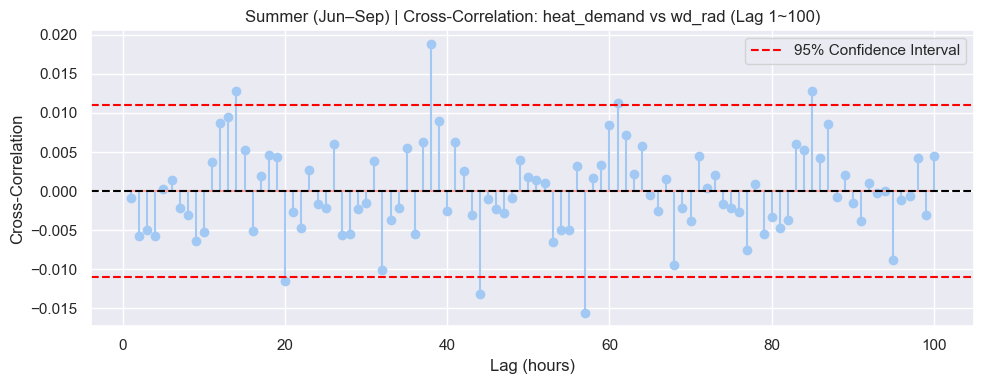

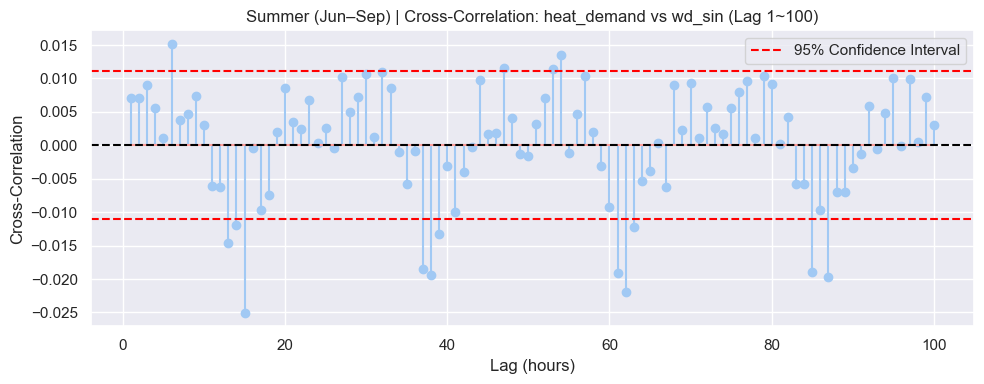

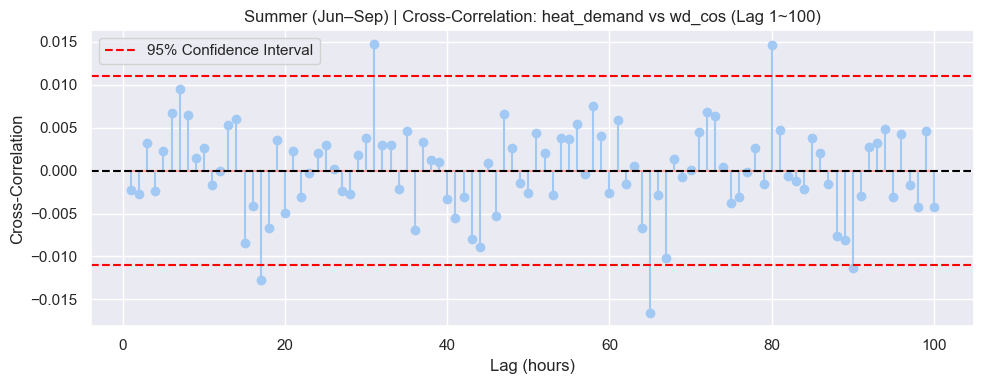

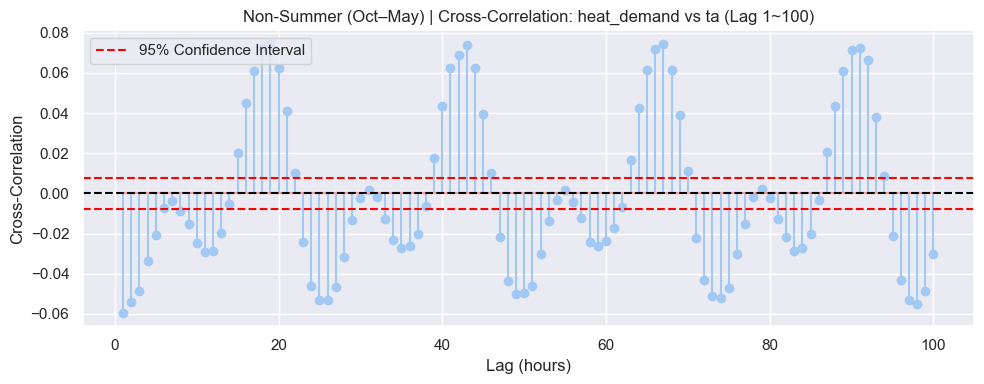

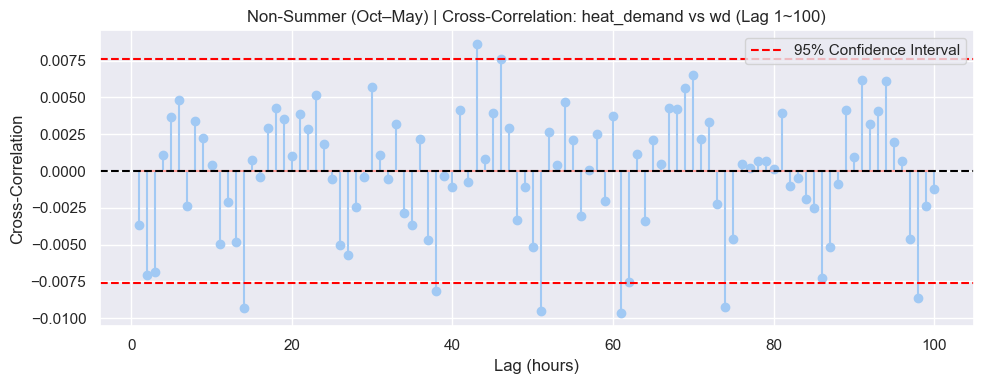

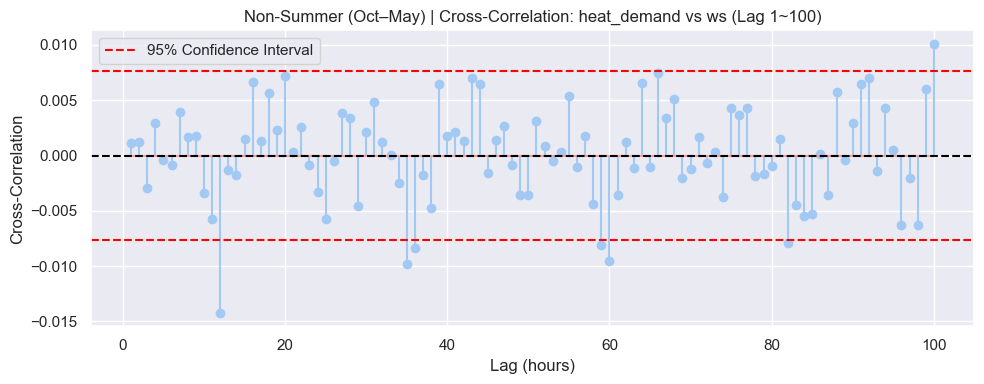

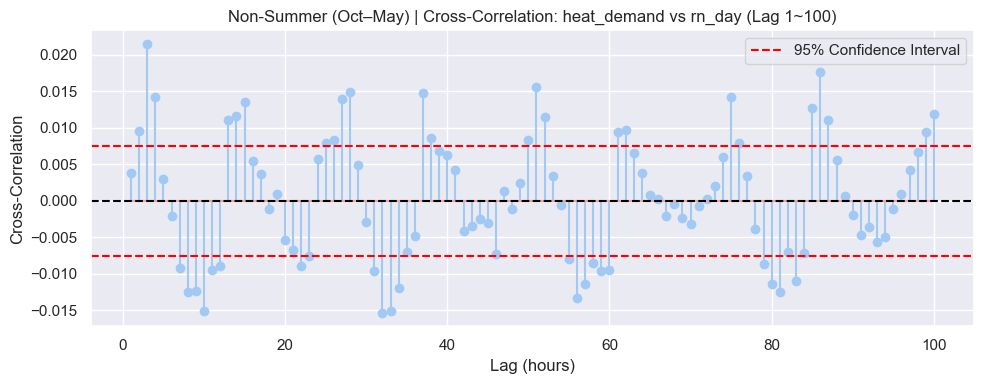

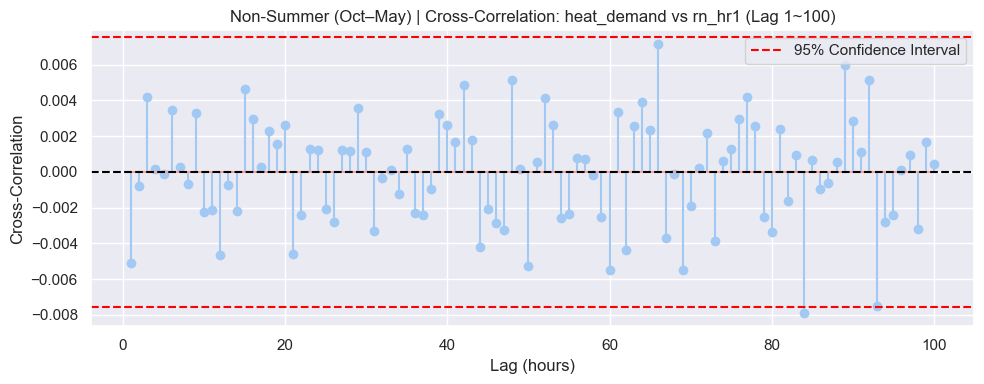

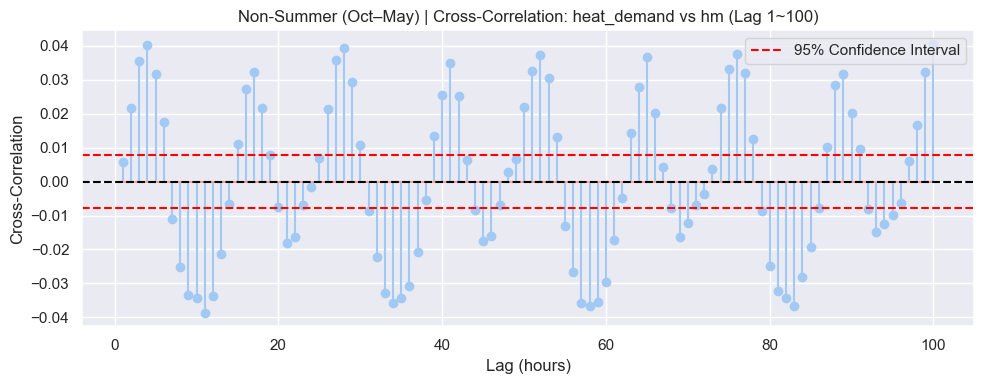

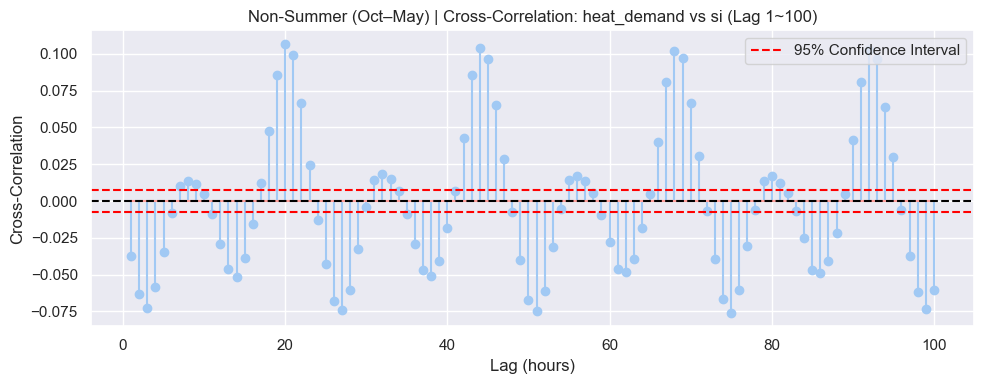

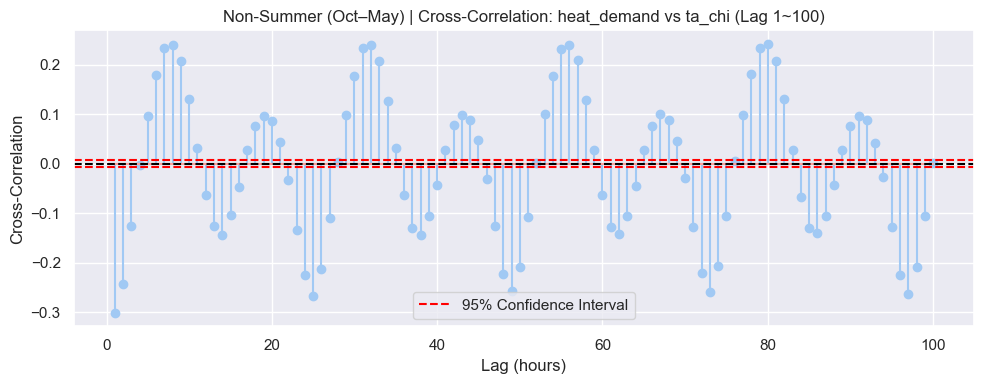

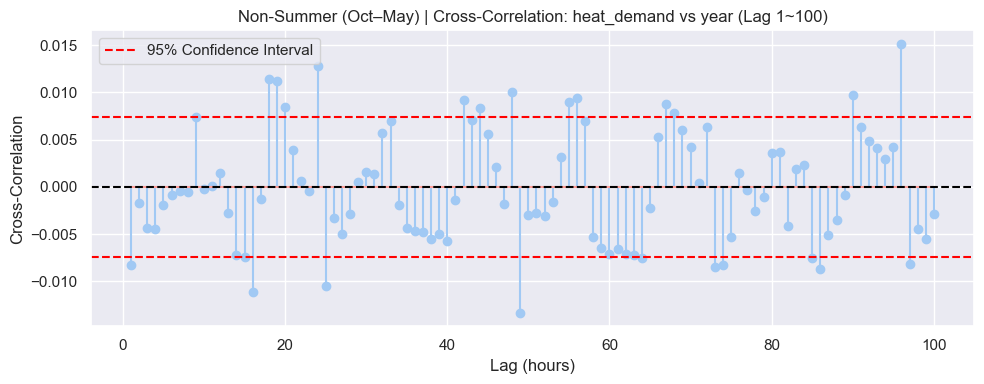

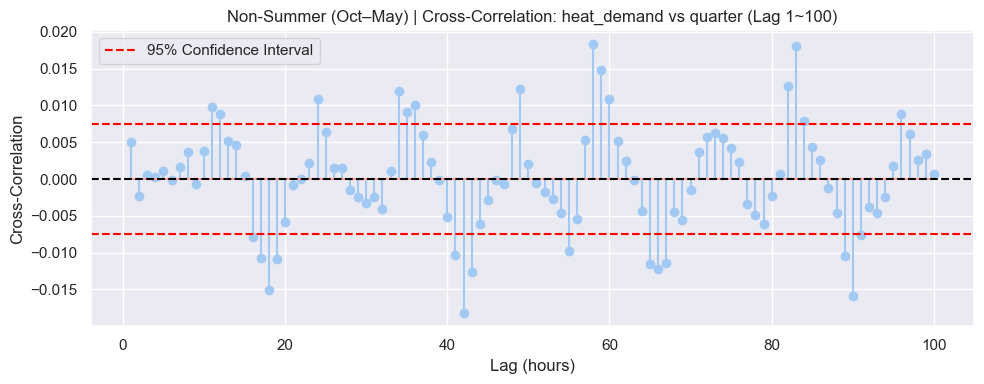

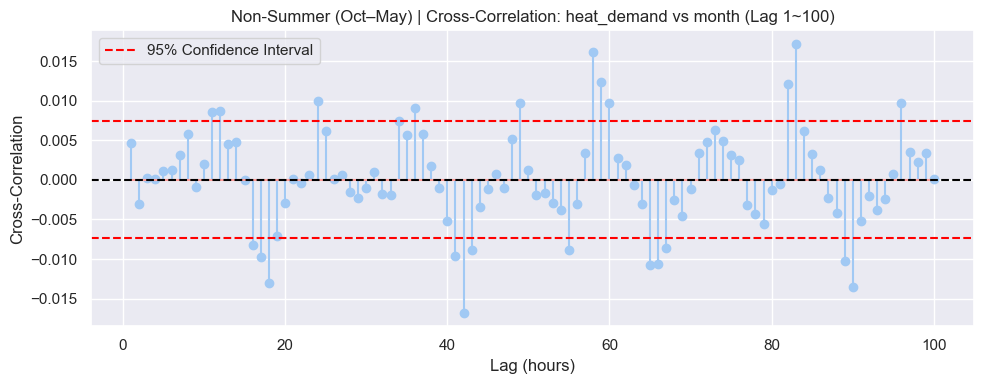

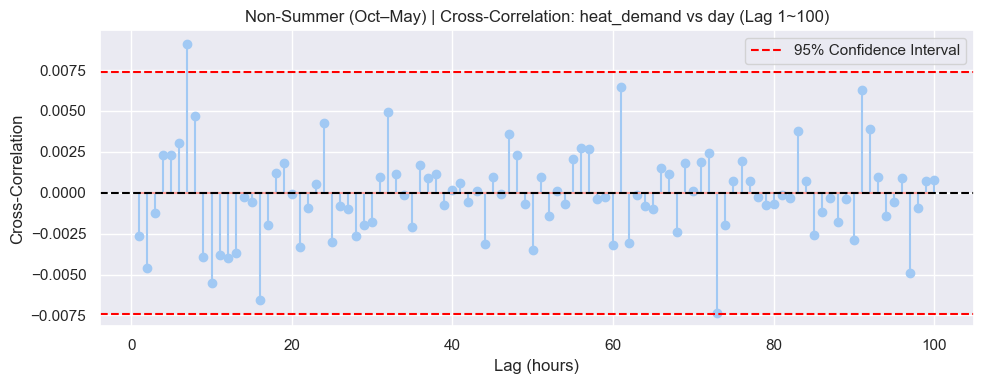

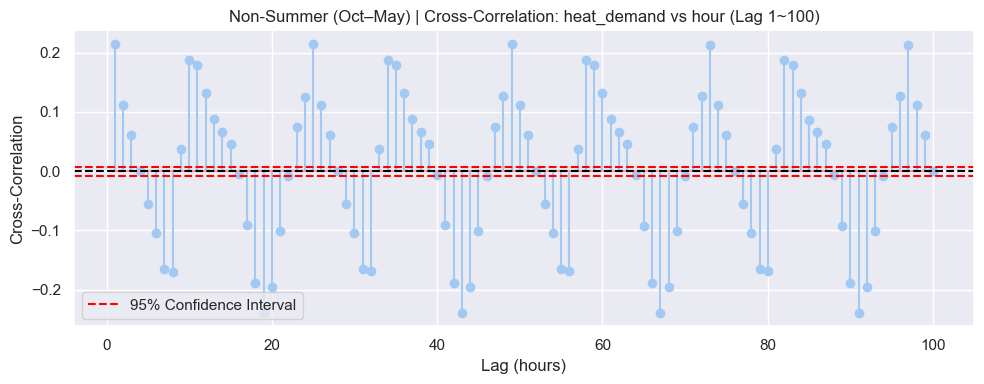

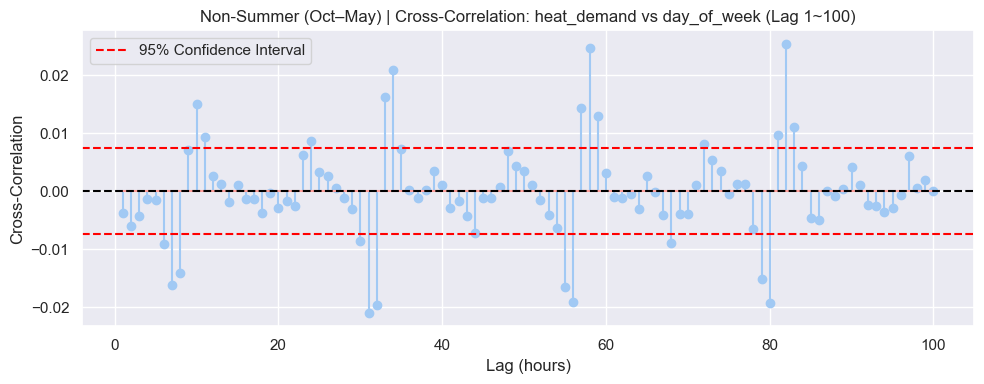

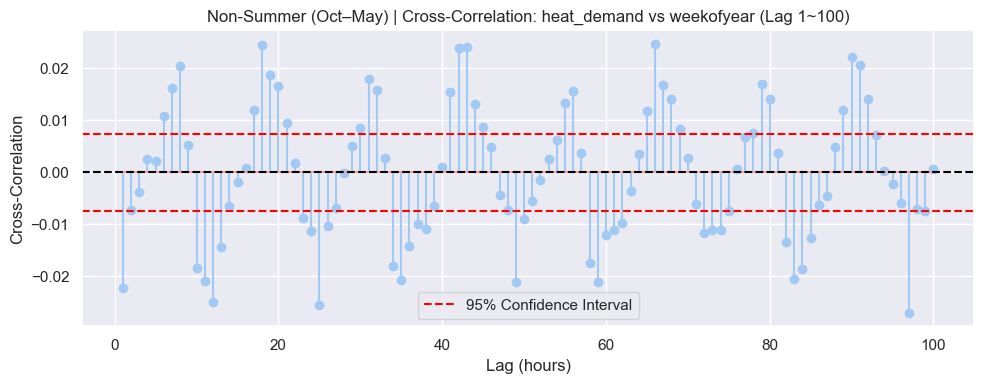

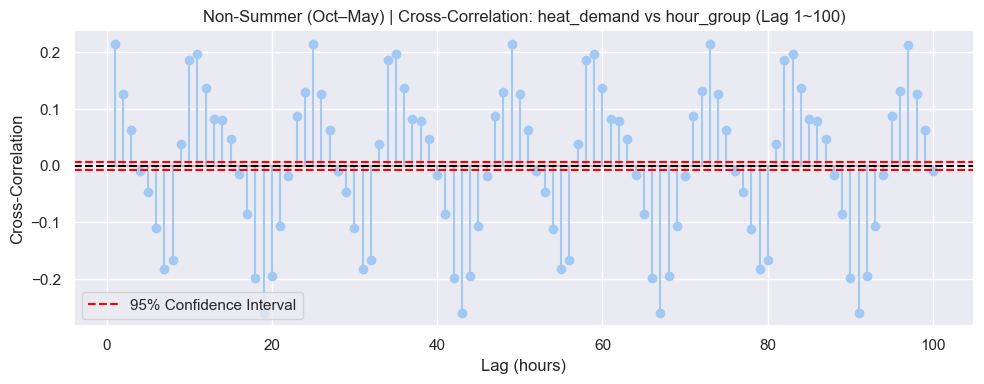

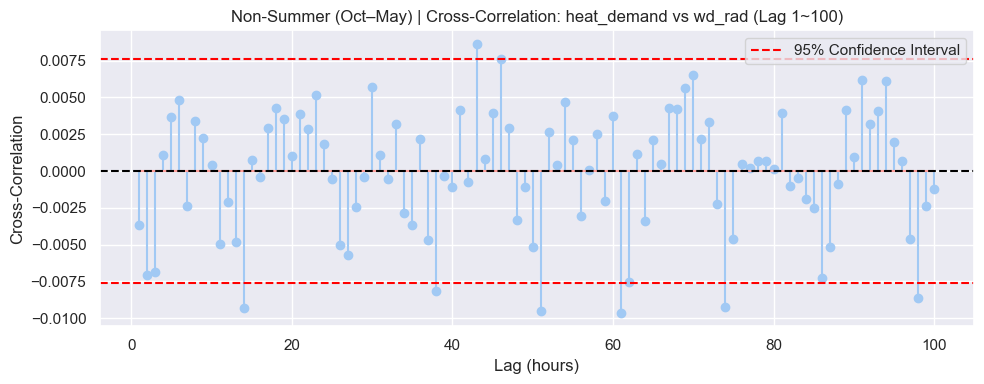

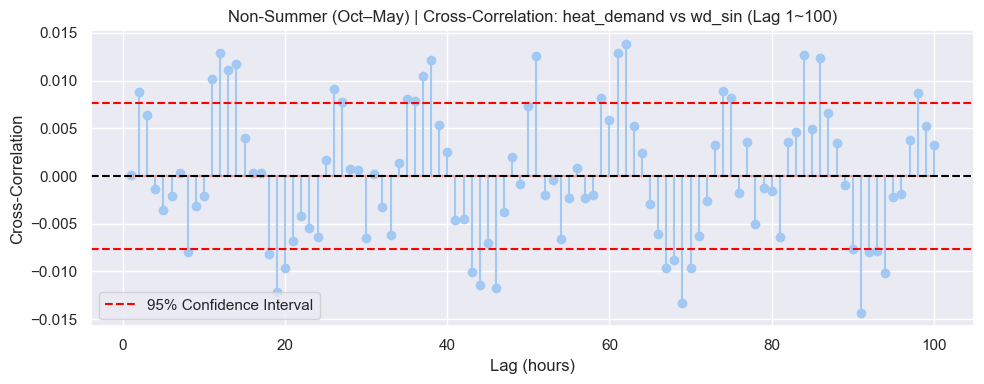

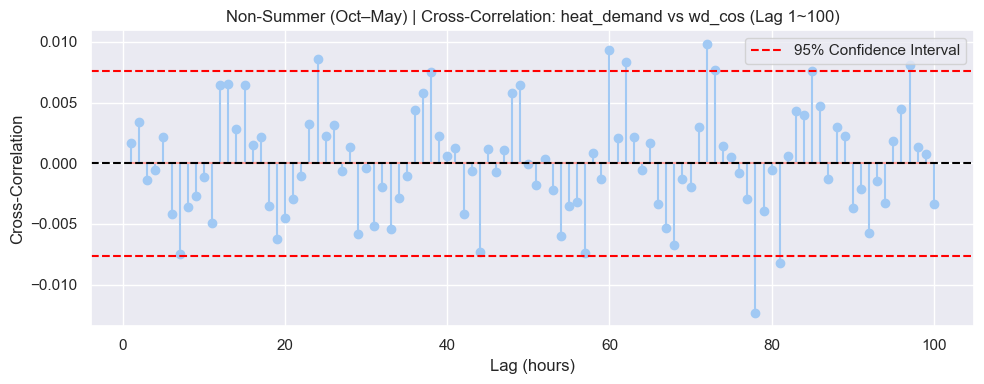

In [22]:
from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# datetime 처리 및 month 추출
df_train_cluster2['tm'] = pd.to_datetime(df_train_cluster2['tm'])
if 'month' not in df_train_cluster2.columns:
    df_train_cluster2['month'] = df_train_cluster2['tm'].dt.month

# 숫자형 변수만 추출
numeric_cols = df_train_cluster2.select_dtypes(include=[np.number]).columns

# 여름 / 비여름 분리
summer_df = df_train_cluster2[df_train_cluster2['month'].isin([6, 7, 8, 9])].copy()
nonsummer_df = df_train_cluster2[~df_train_cluster2['month'].isin([6, 7, 8, 9])].copy()

# CCF 계산 및 시각화 함수
def plot_ccf_by_season(df, label):
    target_var = 'heat_demand'
    variables = [col for col in df.columns if col != target_var and col in numeric_cols]
    
    # 1차 차분
    target_diff = df[target_var].diff().dropna()
    max_lag = 100

    for var in variables:
        var_diff = df[var].diff().dropna()

        # 길이 맞추기
        min_len = min(len(target_diff), len(var_diff))
        x = target_diff[:min_len]
        y = var_diff[:min_len]

        # CCF 계산
        ccf_vals_full = ccf(x, y)
        ccf_vals = ccf_vals_full[1:max_lag + 1]
        lags_range = np.arange(1, max_lag + 1)

        # 신뢰구간
        N = len(x)
        conf_level = 1.96 / np.sqrt(N)

        # 시각화
        plt.figure(figsize=(10, 4))
        plt.stem(lags_range, ccf_vals)
        plt.title(f"{label} | Cross-Correlation: {target_var} vs {var} (Lag 1~{max_lag})")
        plt.xlabel("Lag (hours)")
        plt.ylabel("Cross-Correlation")
        plt.grid(True)
        plt.axhline(0, color='black', linestyle='--')
        plt.axhline(conf_level, color='red', linestyle='--', label='95% Confidence Interval')
        plt.axhline(-conf_level, color='red', linestyle='--')
        plt.legend()
        plt.tight_layout()
        plt.show()

# 실행
plot_ccf_by_season(summer_df, "Summer (Jun–Sep)")
plot_ccf_by_season(nonsummer_df, "Non-Summer (Oct–May)")


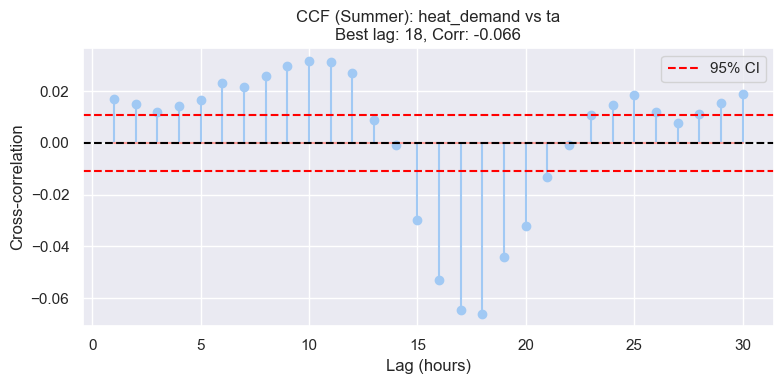

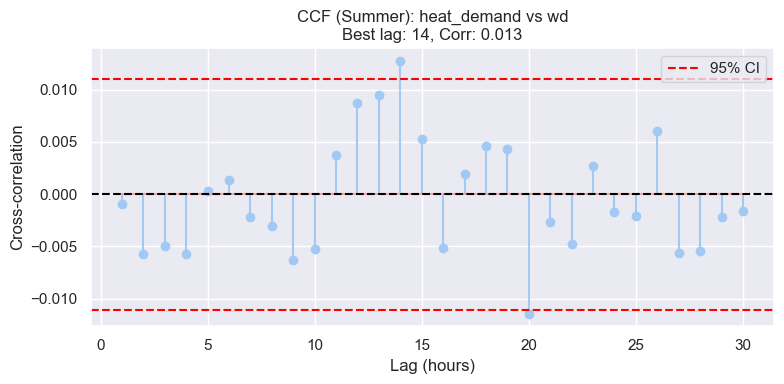

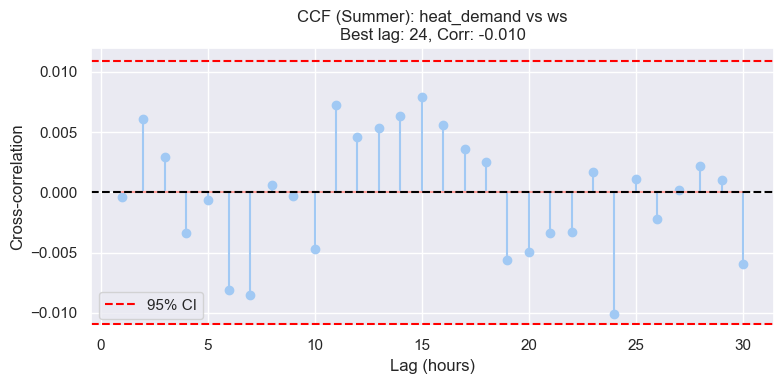

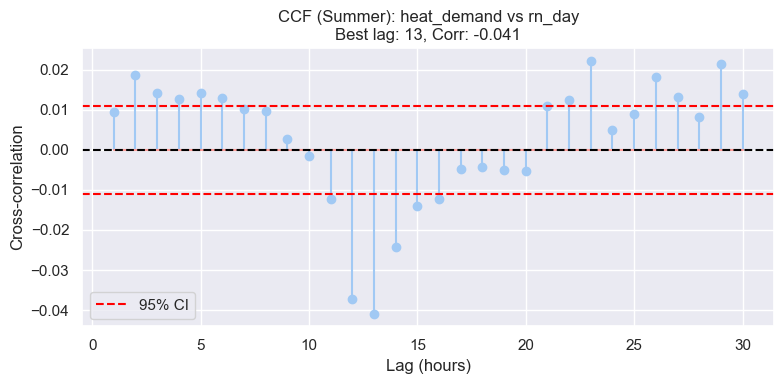

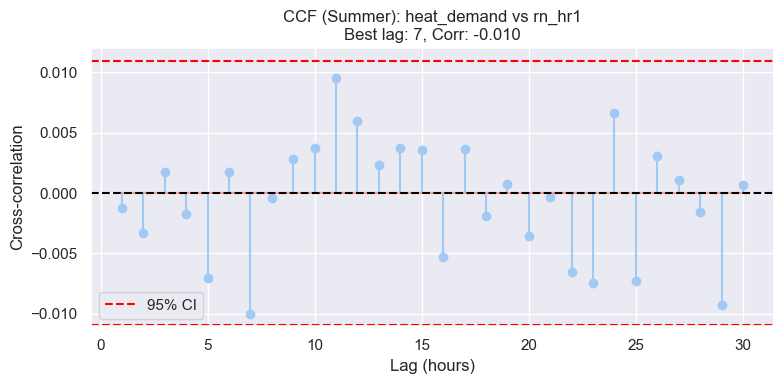

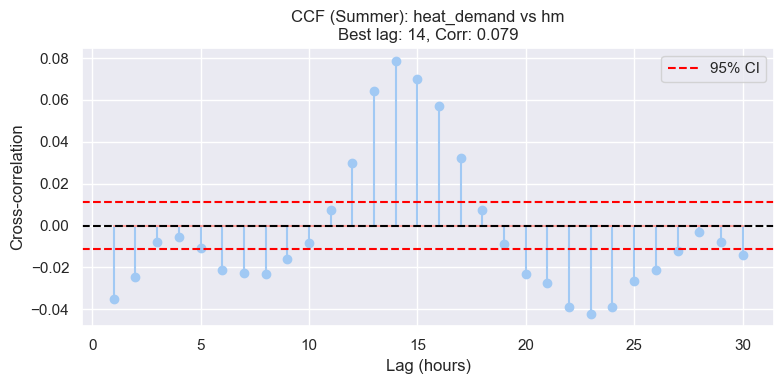

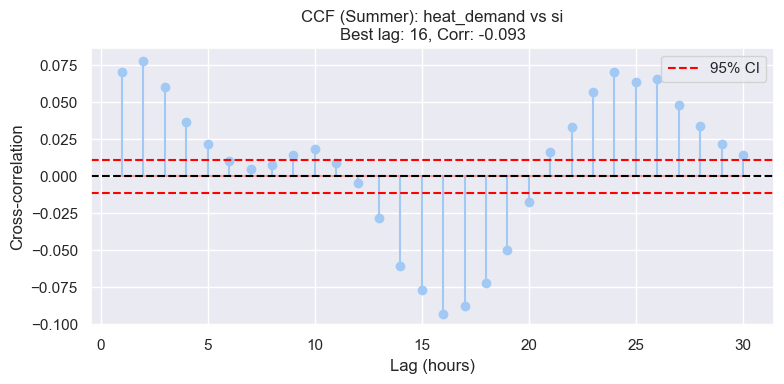

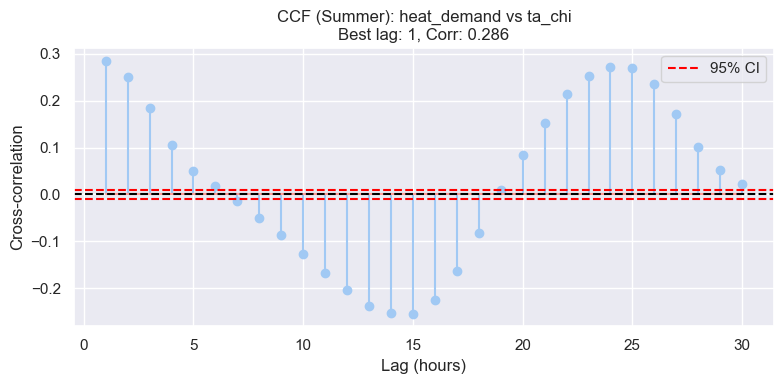

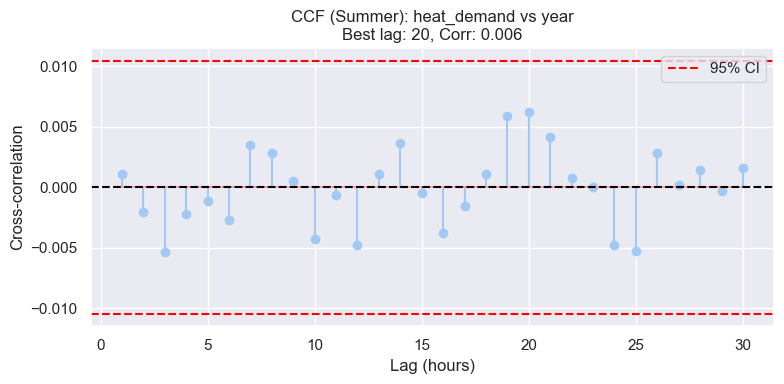

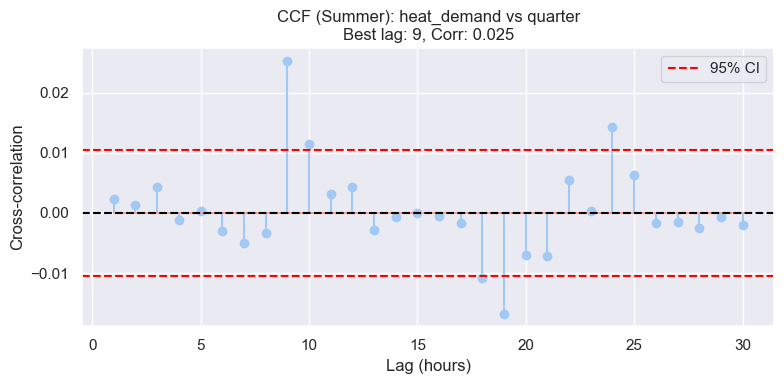

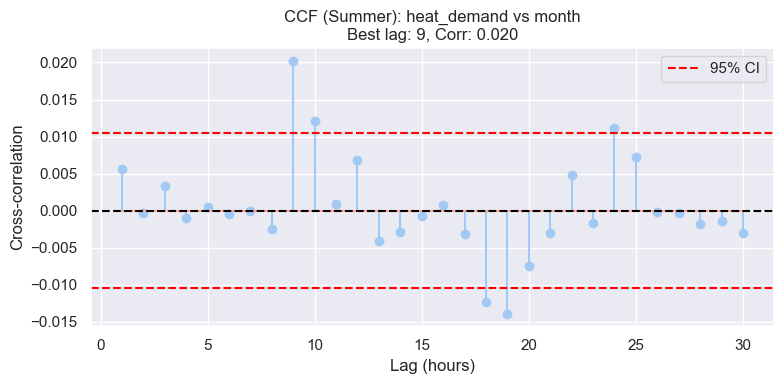

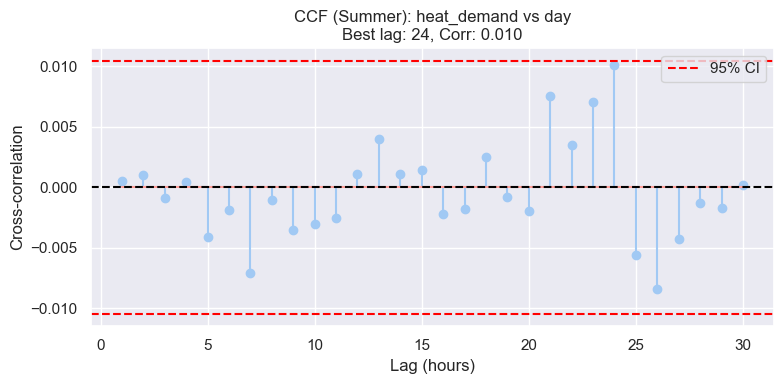

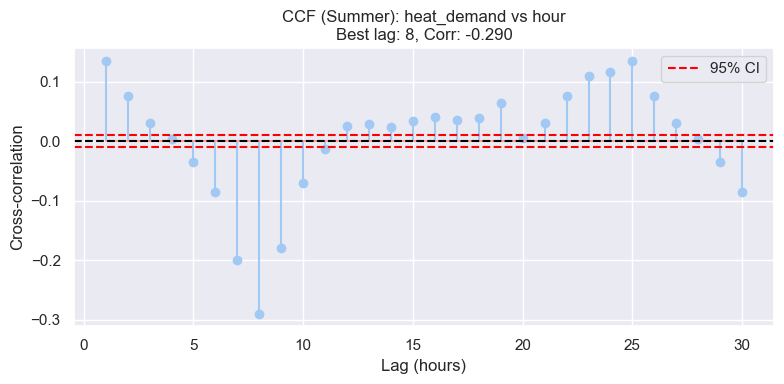

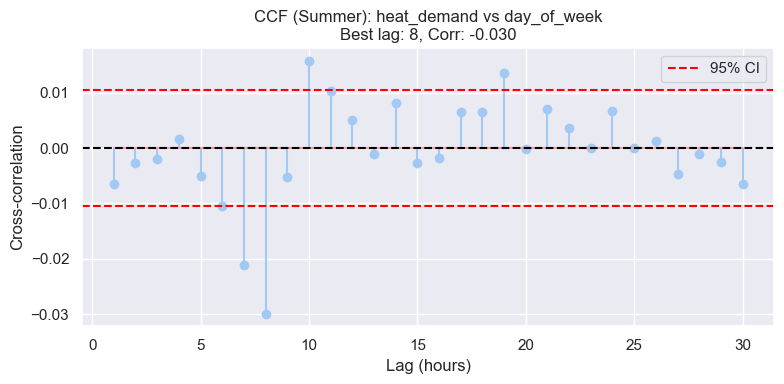

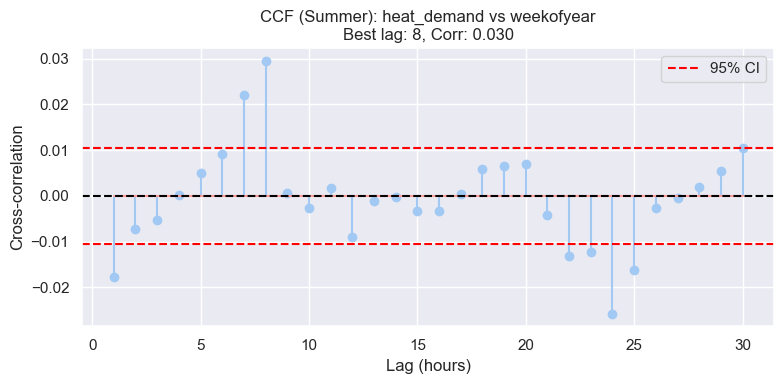

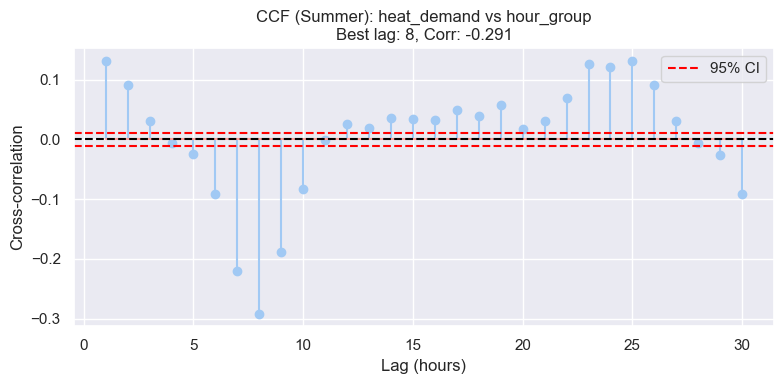

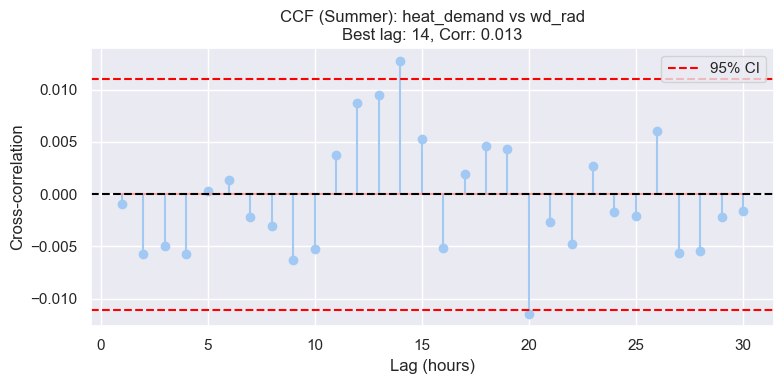

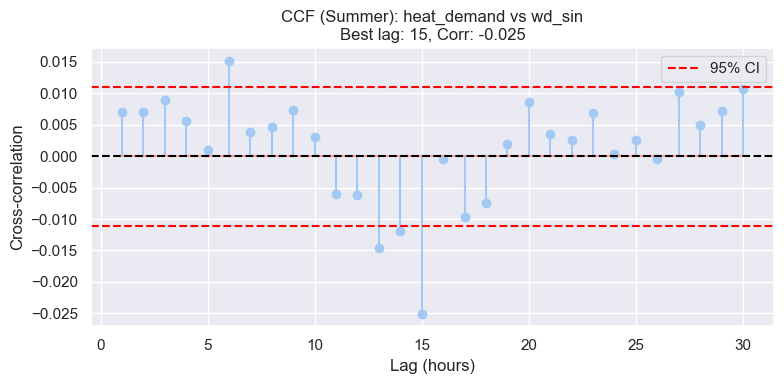

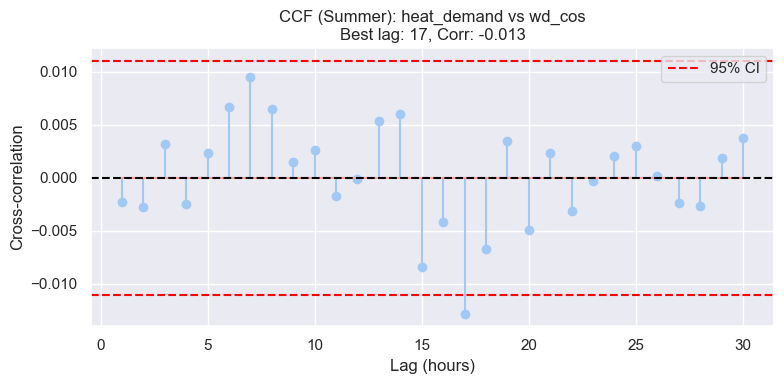

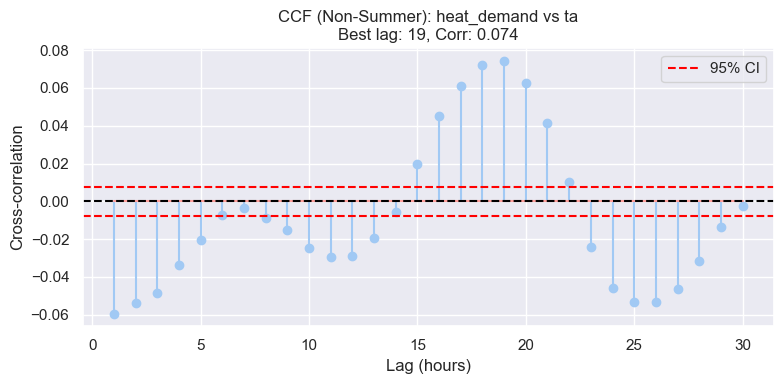

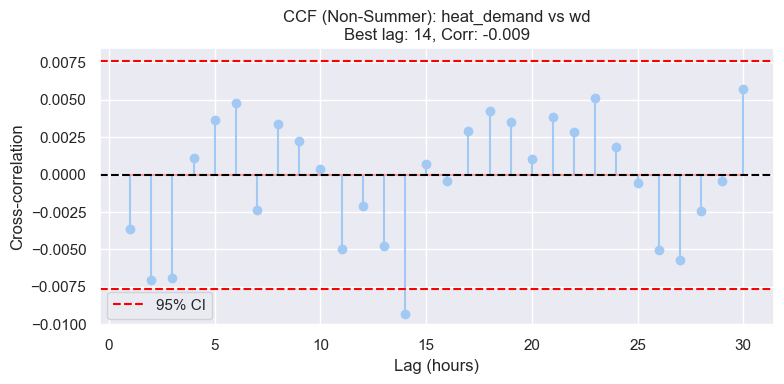

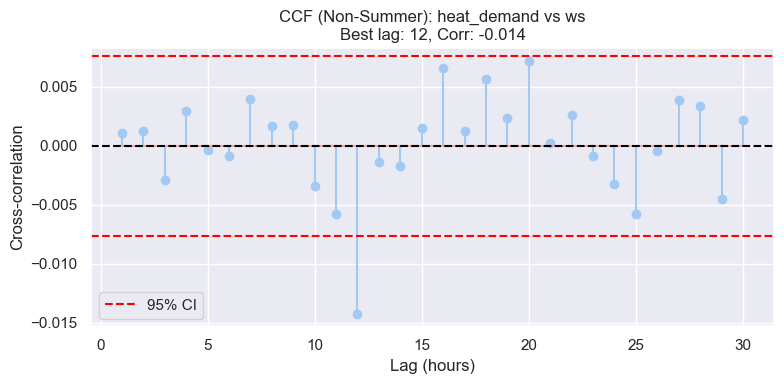

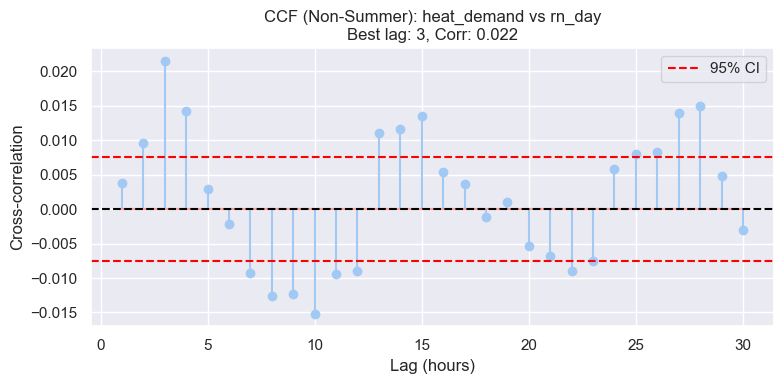

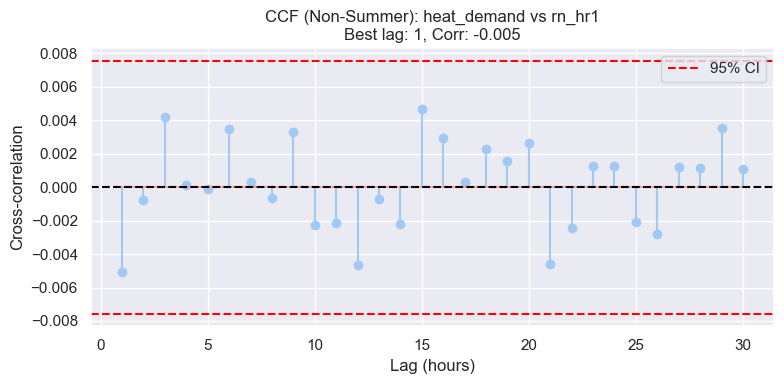

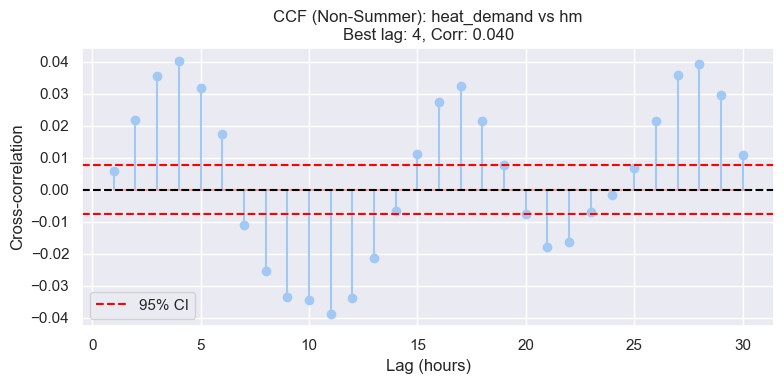

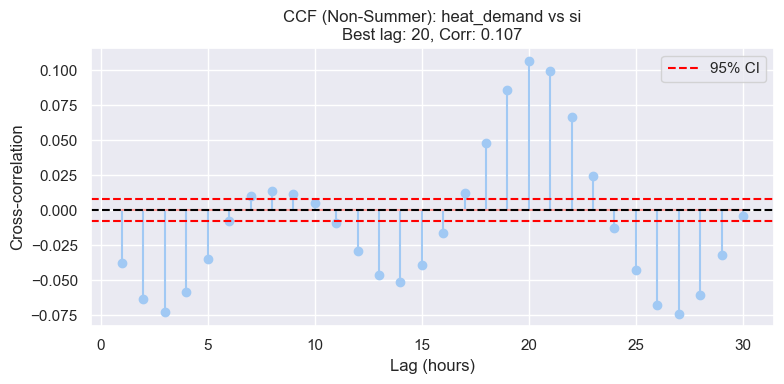

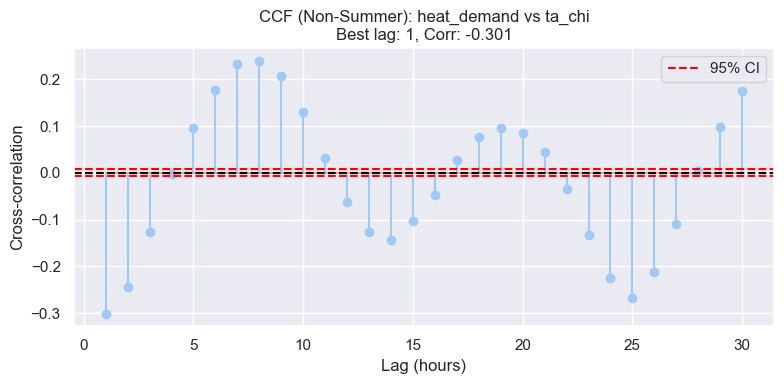

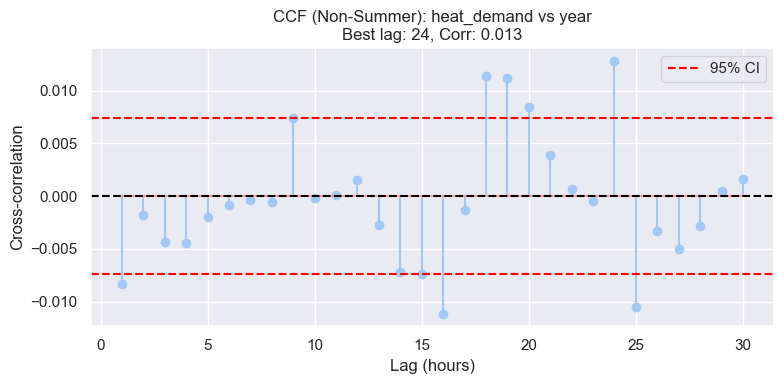

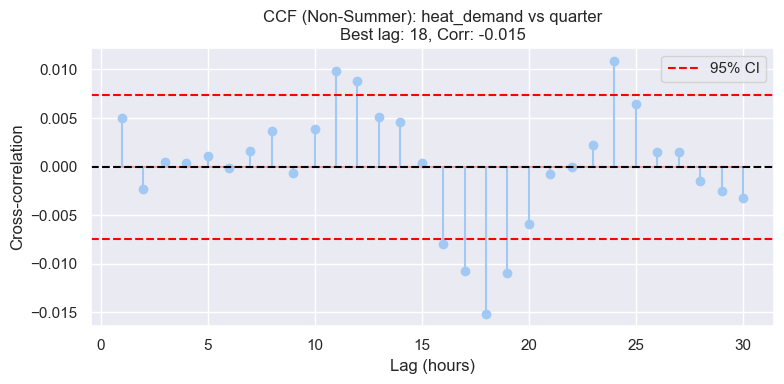

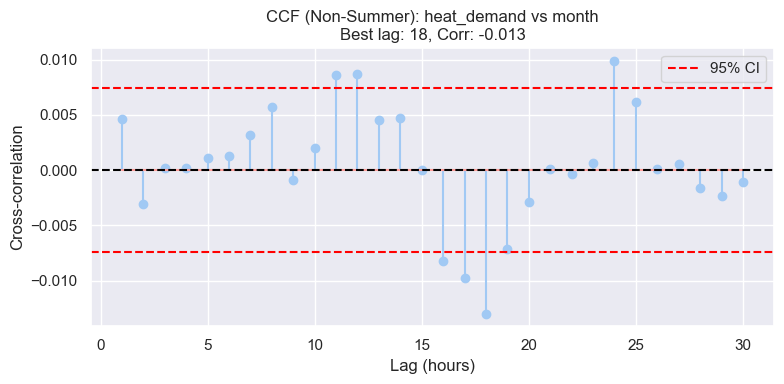

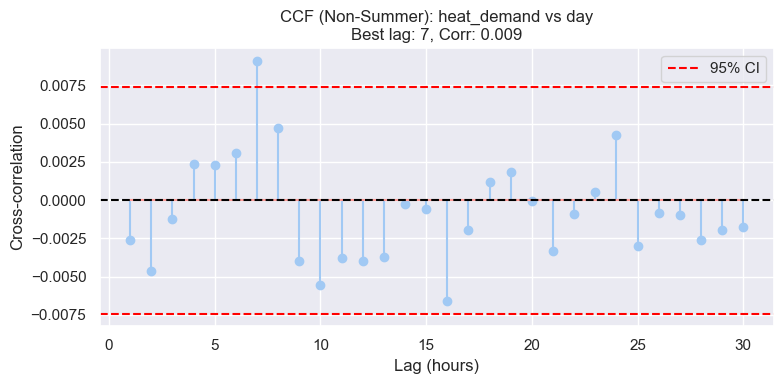

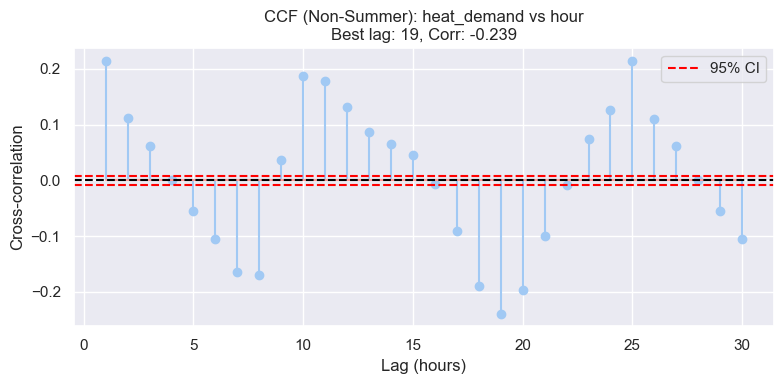

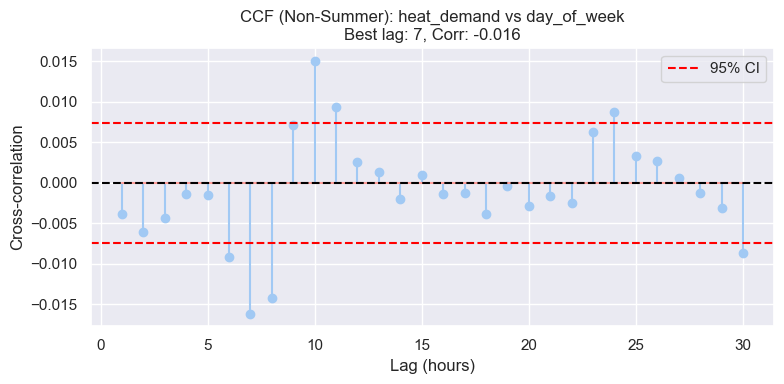

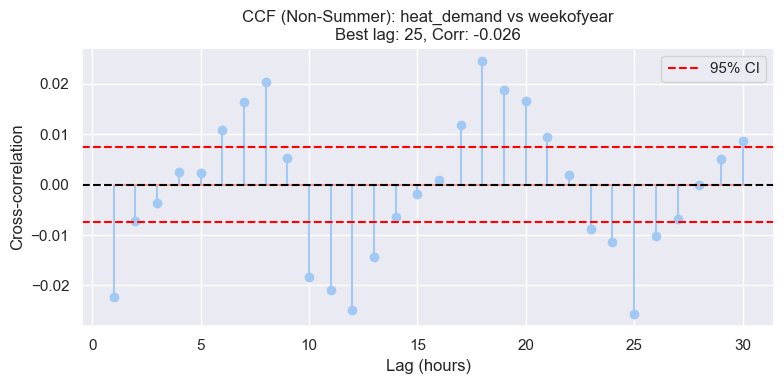

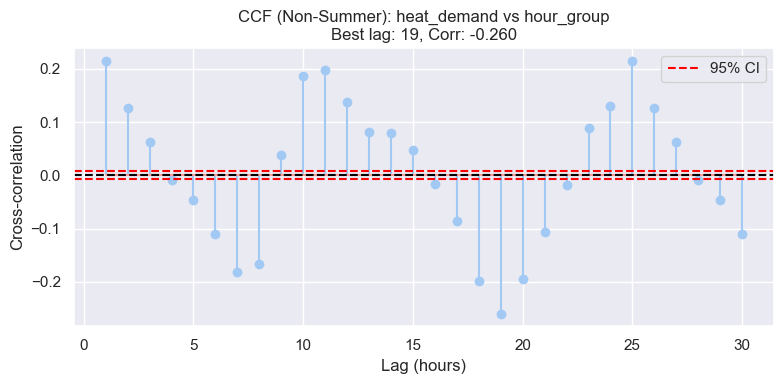

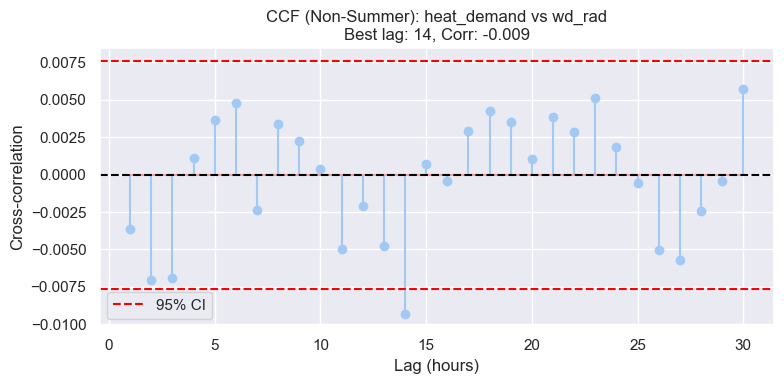

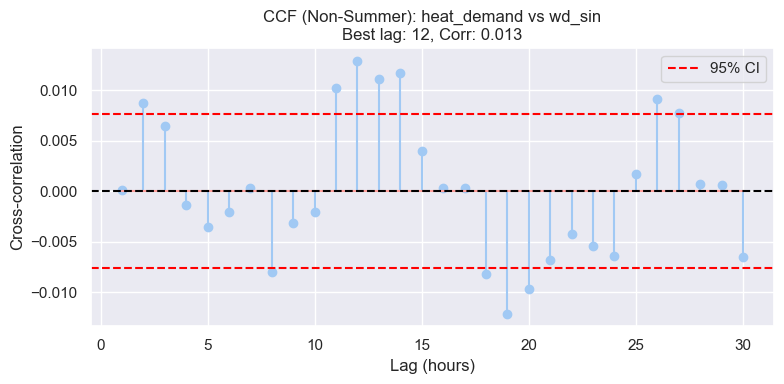

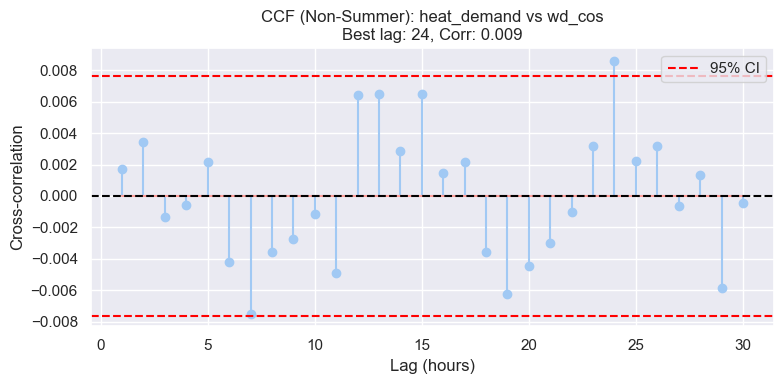

Summer lags: {'ta': {'best_lag': np.int64(18), 'ccf_value': np.float64(-0.06594911851161787)}, 'wd': {'best_lag': np.int64(14), 'ccf_value': np.float64(0.012764077356068352)}, 'ws': {'best_lag': np.int64(24), 'ccf_value': np.float64(-0.01007086136540322)}, 'rn_day': {'best_lag': np.int64(13), 'ccf_value': np.float64(-0.04088014407365504)}, 'rn_hr1': {'best_lag': np.int64(7), 'ccf_value': np.float64(-0.009989328802671513)}, 'hm': {'best_lag': np.int64(14), 'ccf_value': np.float64(0.07870090640053491)}, 'si': {'best_lag': np.int64(16), 'ccf_value': np.float64(-0.09275667421967027)}, 'ta_chi': {'best_lag': np.int64(1), 'ccf_value': np.float64(0.2855204707917412)}, 'year': {'best_lag': np.int64(20), 'ccf_value': np.float64(0.006195341133323355)}, 'quarter': {'best_lag': np.int64(9), 'ccf_value': np.float64(0.025322488532695548)}, 'month': {'best_lag': np.int64(9), 'ccf_value': np.float64(0.02023185955048785)}, 'day': {'best_lag': np.int64(24), 'ccf_value': np.float64(0.010142368207939954)}

In [30]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt

def is_summer(date):
    return date.month in [6,7,8,9]

df = df_train_cluster2.copy()
df['tm'] = pd.to_datetime(df['tm'])
df['is_summer'] = df['tm'].apply(is_summer)
df = df.set_index('tm')

target_var = 'heat_demand'
variables = [col for col in df.select_dtypes(include=[np.number]).columns if col not in [target_var, 'is_summer']]

max_lag = 30

def find_best_lag_and_plot(df_group, group_name):
    target = df_group[target_var].dropna()
    results = {}

    for var in variables:
        x = target.diff().dropna()
        y = df_group[var].diff().dropna()
        
        min_len = min(len(x), len(y))
        x = x[:min_len]
        y = y[:min_len]
        
        ccf_vals = ccf(x, y)[:max_lag+1]
        ccf_vals_lags = ccf_vals[1:]

        best_lag = np.argmax(np.abs(ccf_vals_lags)) + 1
        best_corr = ccf_vals_lags[best_lag-1]
        
        results[var] = {'best_lag': best_lag, 'ccf_value': best_corr}
        
        plt.figure(figsize=(8,4))
        lags = np.arange(1, max_lag+1)
        plt.stem(lags, ccf_vals_lags)  # 수정된 부분
        plt.axhline(0, color='black', linestyle='--')
        N = len(x)
        conf_level = 1.96 / np.sqrt(N)
        plt.axhline(conf_level, color='red', linestyle='--', label='95% CI')
        plt.axhline(-conf_level, color='red', linestyle='--')
        plt.title(f"CCF ({group_name}): heat_demand vs {var}\nBest lag: {best_lag}, Corr: {best_corr:.3f}")
        plt.xlabel("Lag (hours)")
        plt.ylabel("Cross-correlation")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return results

summer_lags = find_best_lag_and_plot(df[df['is_summer']], "Summer")
non_summer_lags = find_best_lag_and_plot(df[~df['is_summer']], "Non-Summer")

print("Summer lags:", summer_lags)
print("Non-Summer lags:", non_summer_lags)


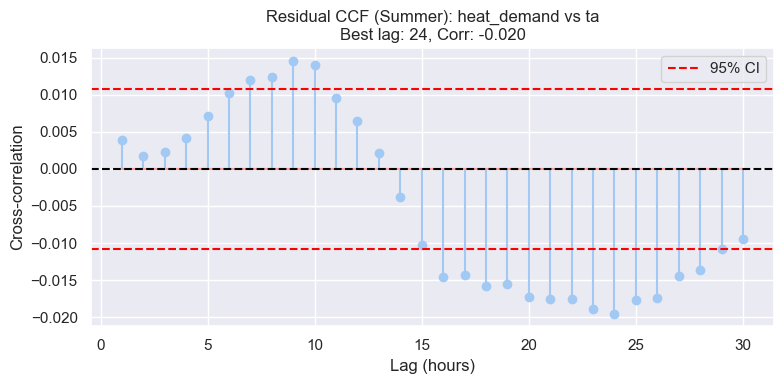

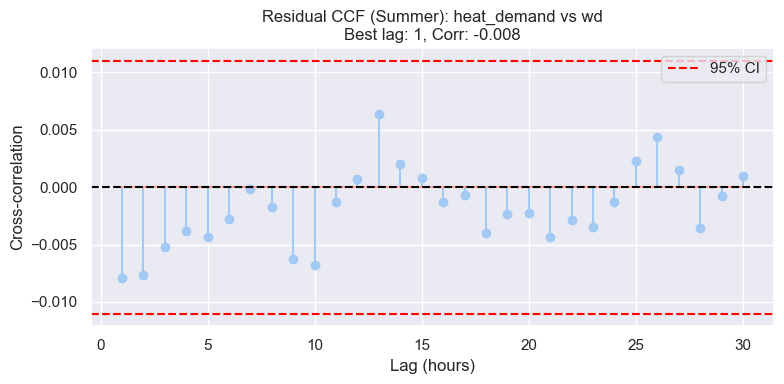

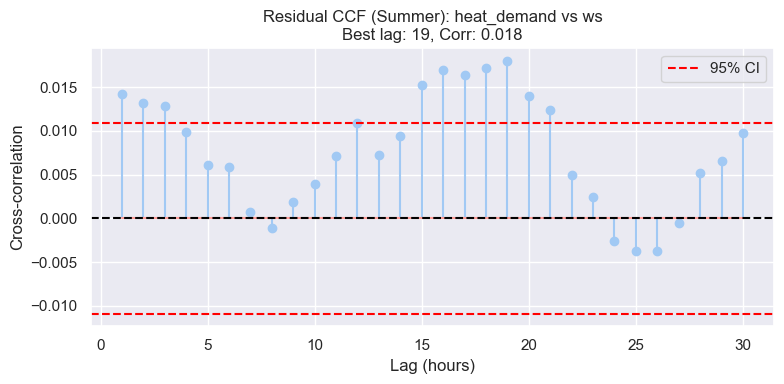

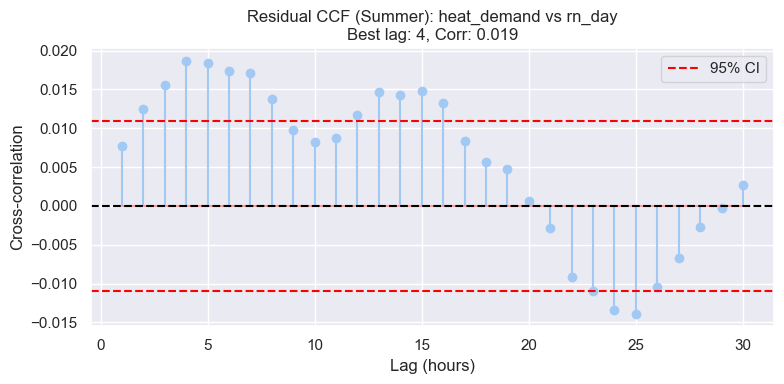

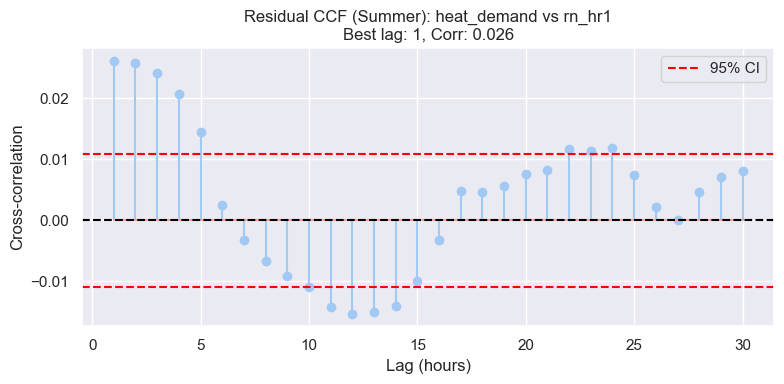

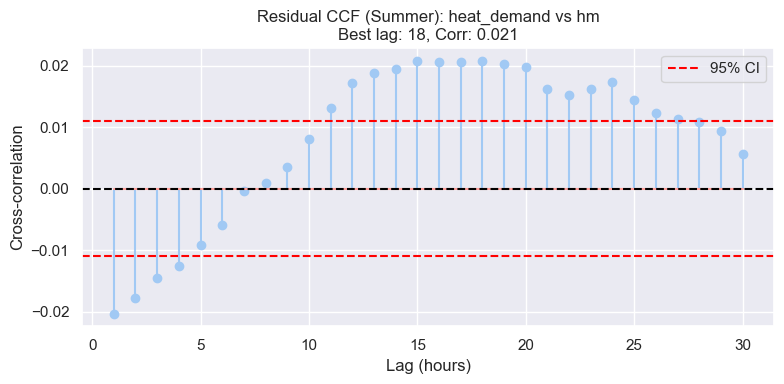

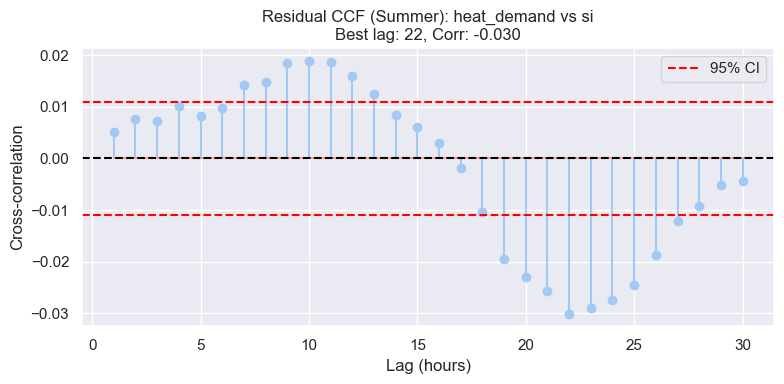

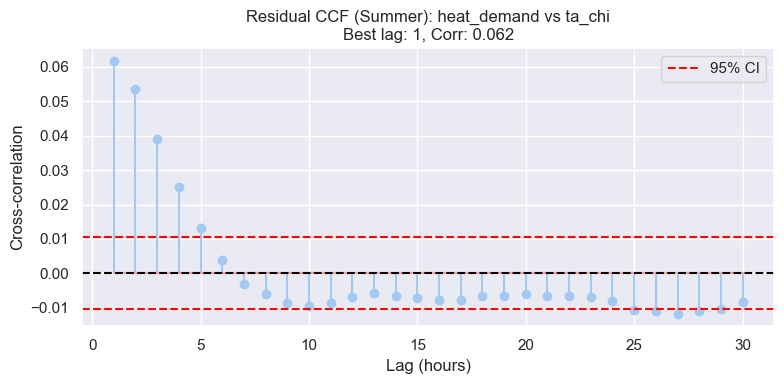

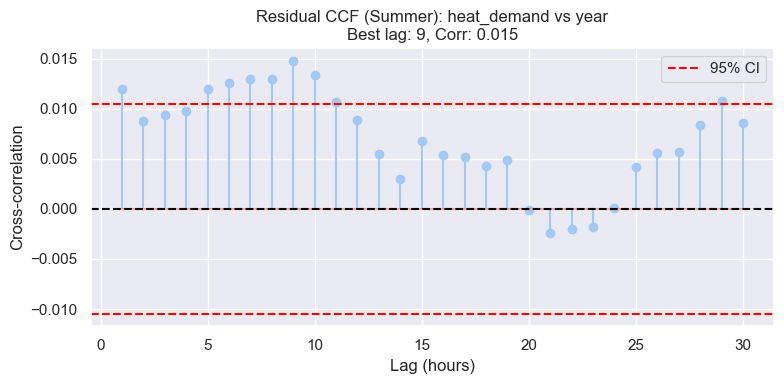

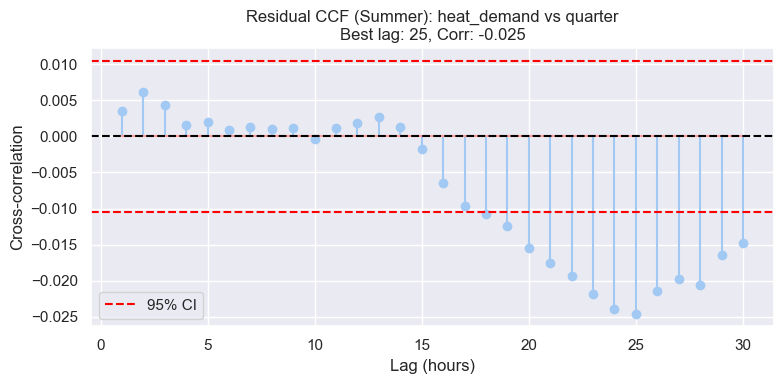

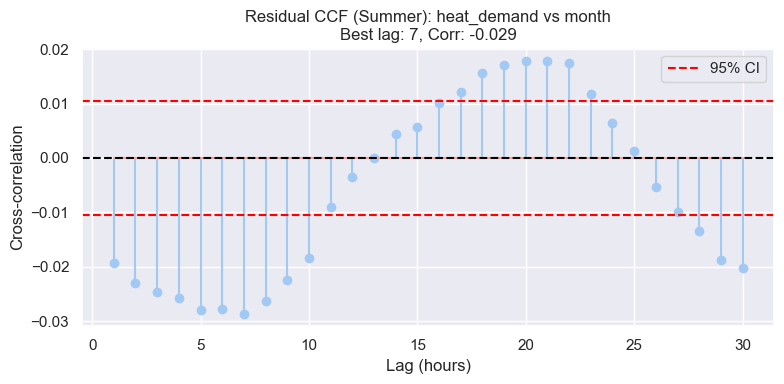

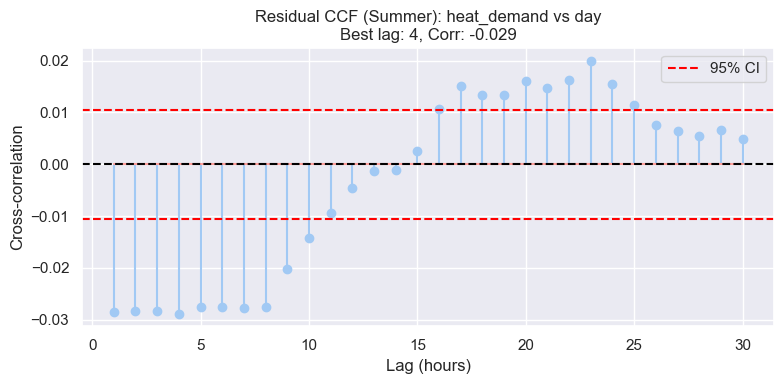

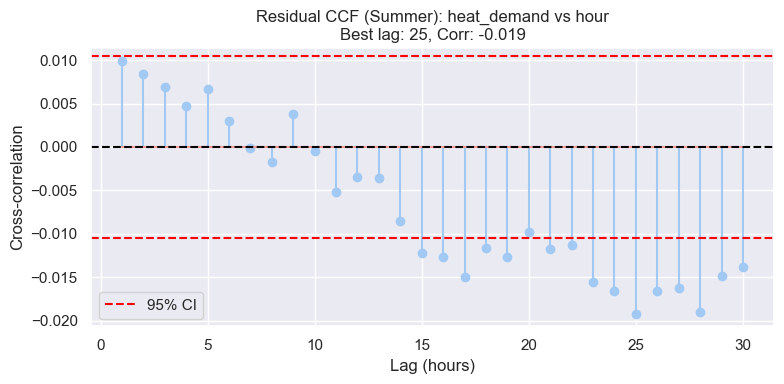

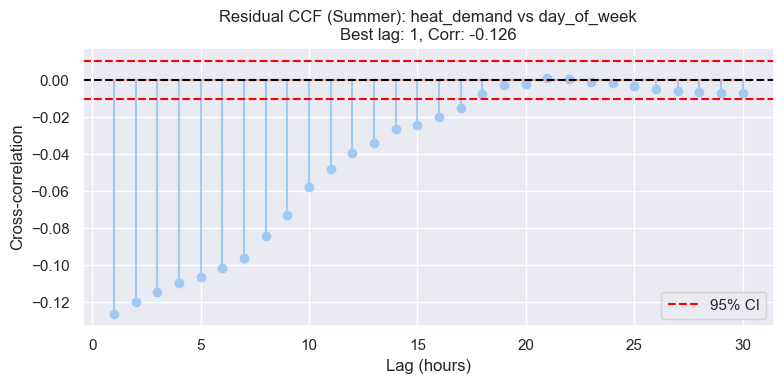

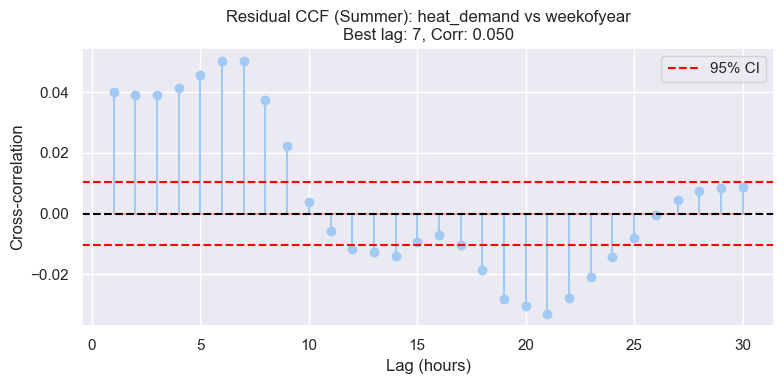

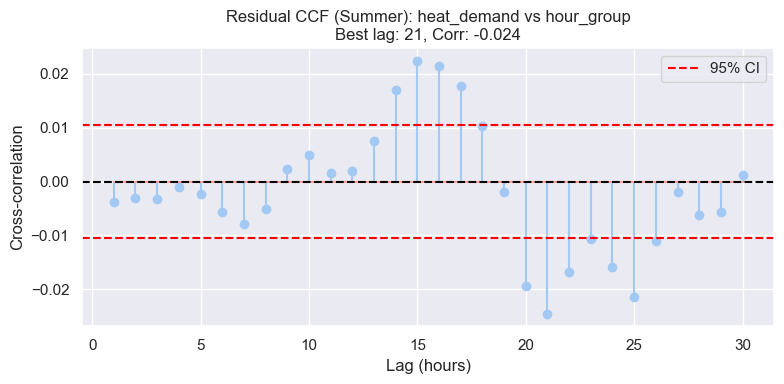

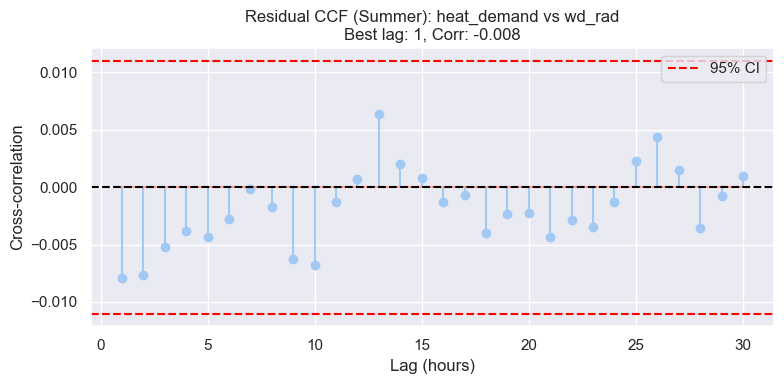

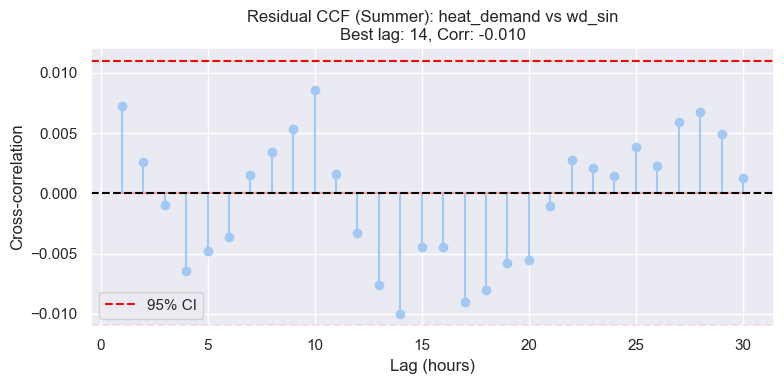

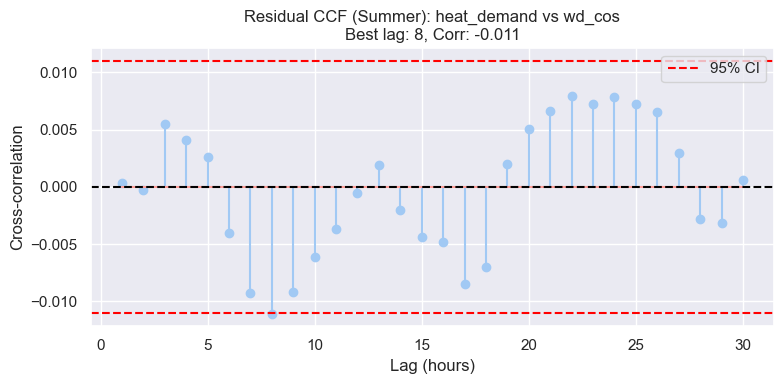

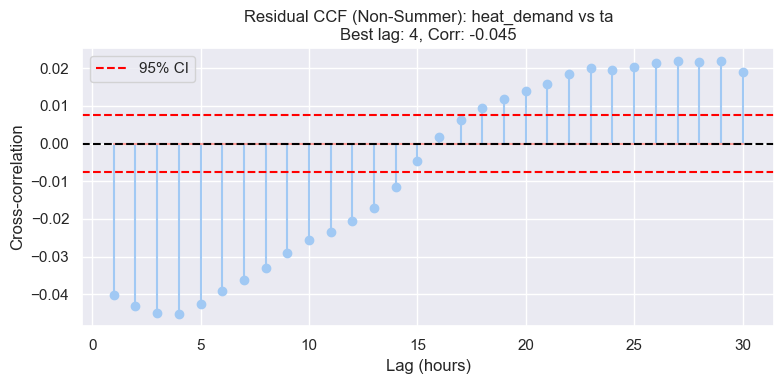

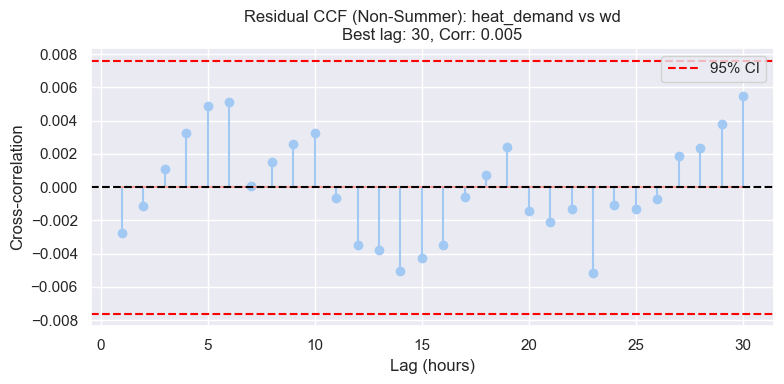

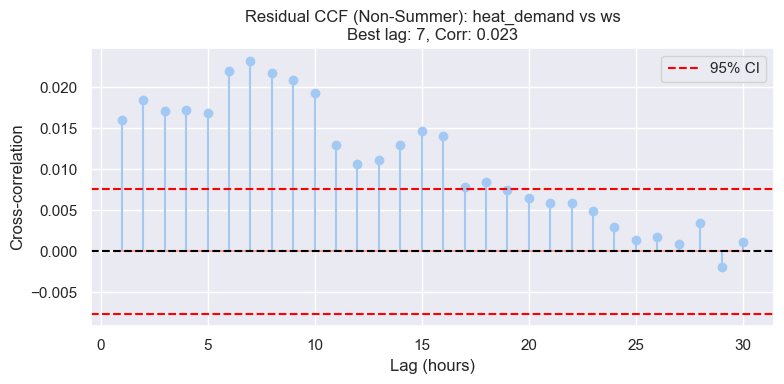

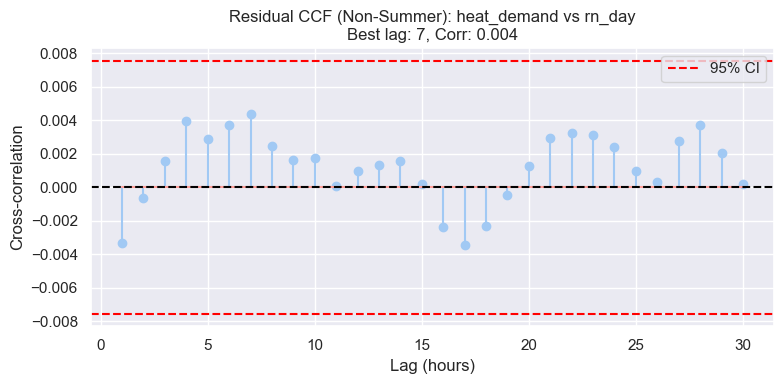

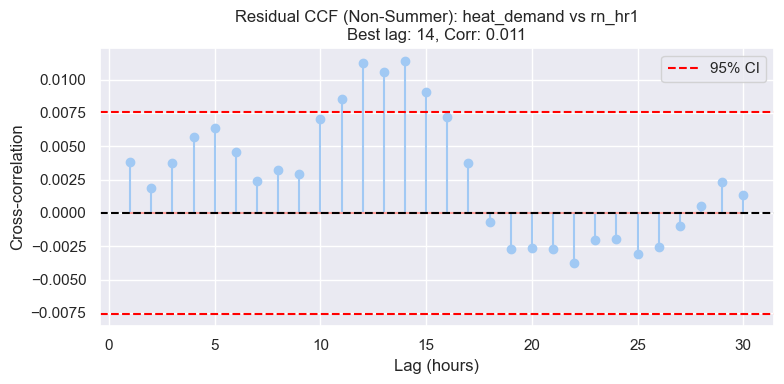

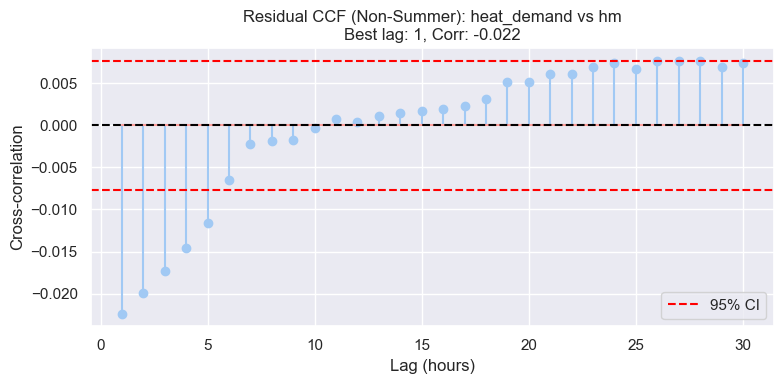

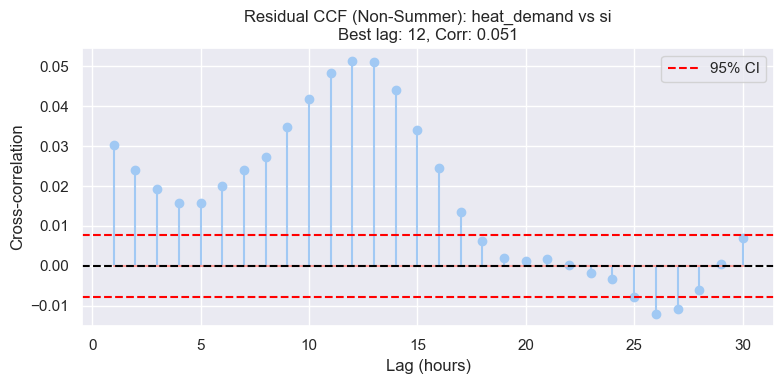

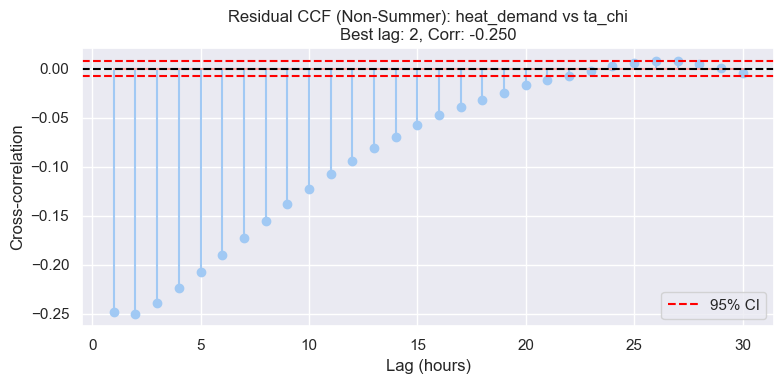

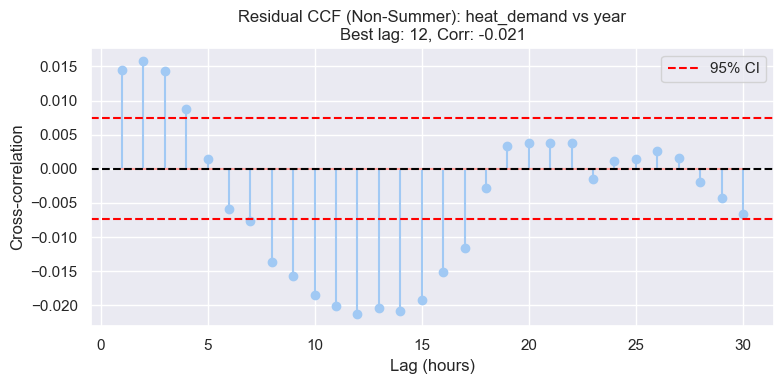

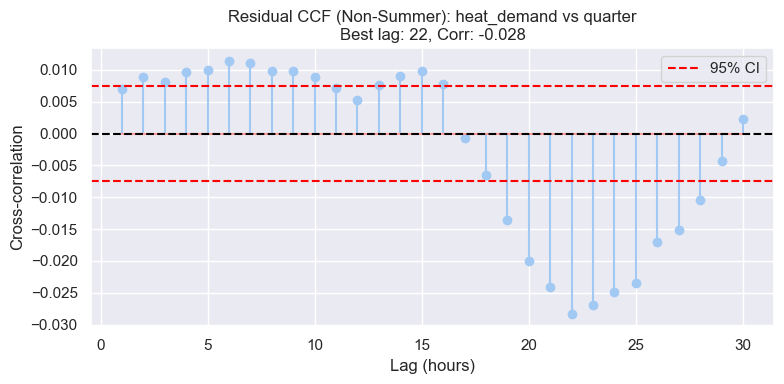

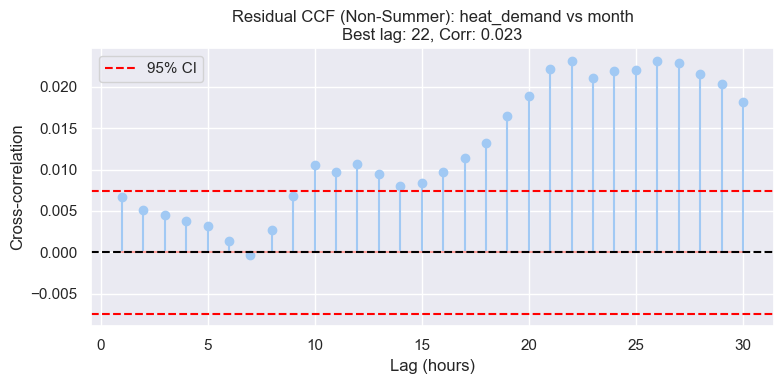

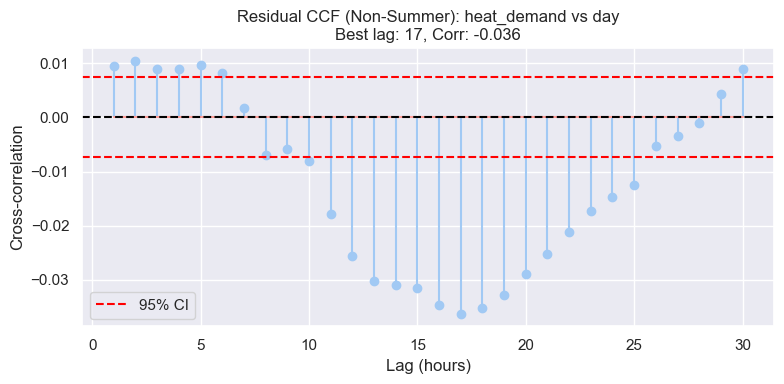

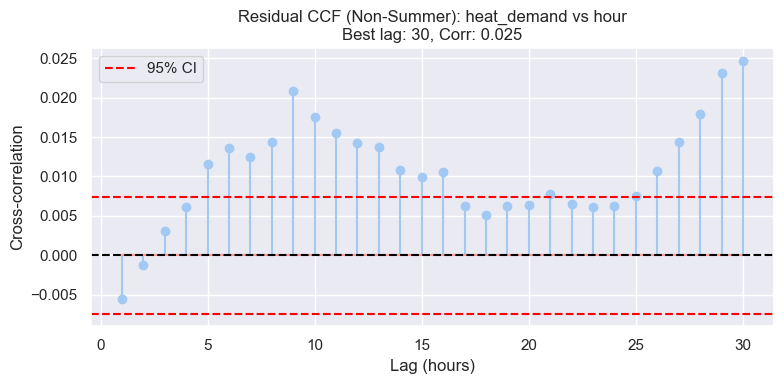

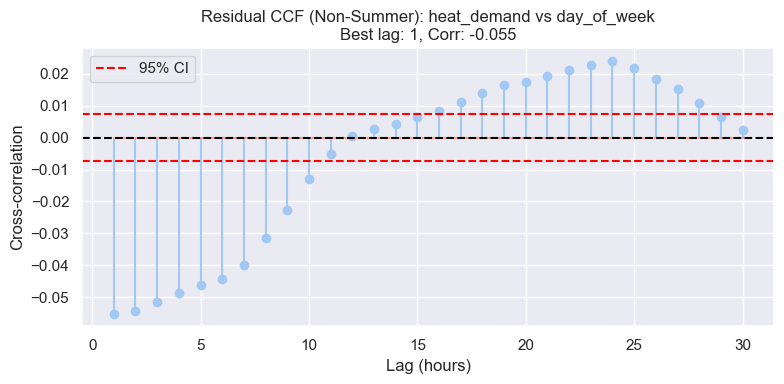

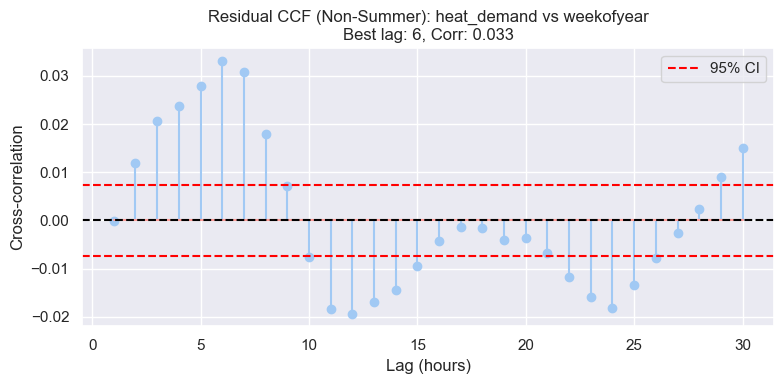

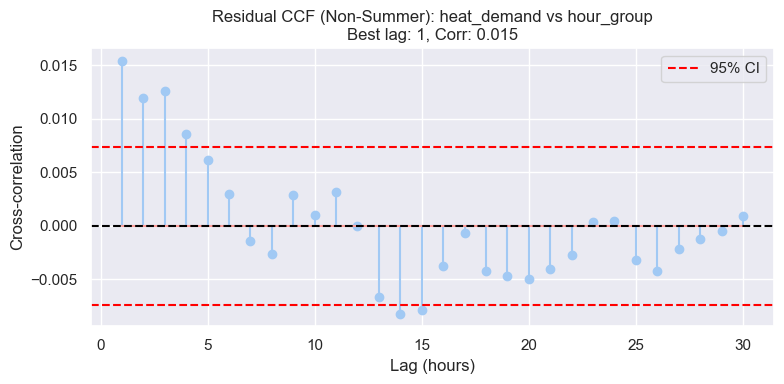

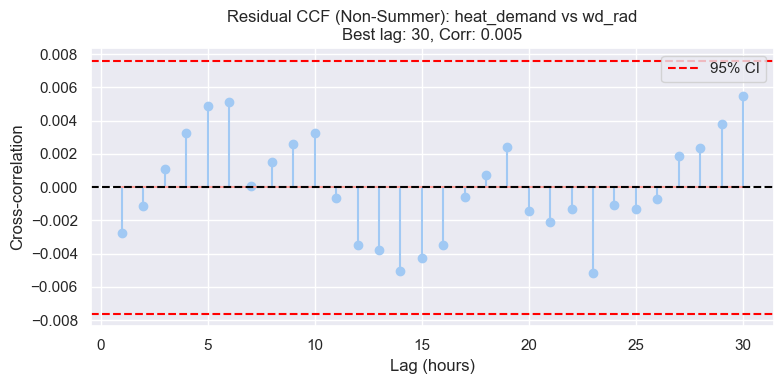

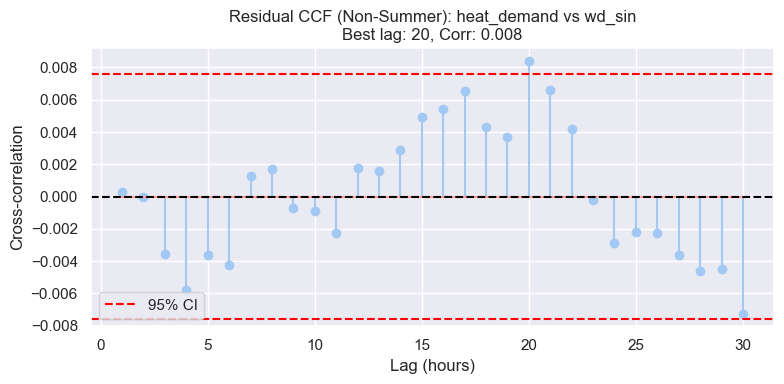

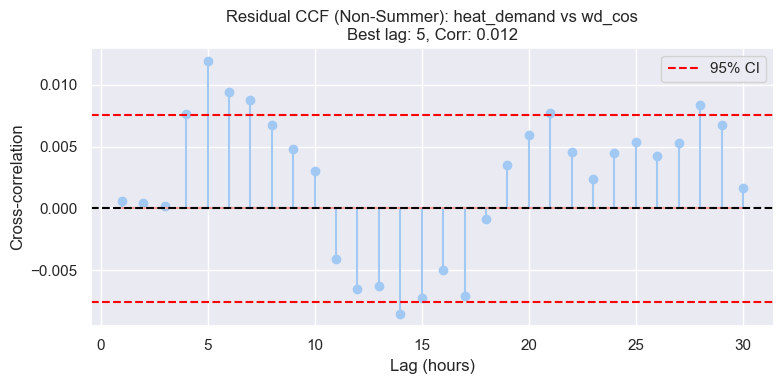

Summer lags: {'ta': {'best_lag': np.int64(24), 'ccf_value': np.float64(-0.019522061799313442)}, 'wd': {'best_lag': np.int64(1), 'ccf_value': np.float64(-0.007872369639311313)}, 'ws': {'best_lag': np.int64(19), 'ccf_value': np.float64(0.018026082589269635)}, 'rn_day': {'best_lag': np.int64(4), 'ccf_value': np.float64(0.01870042325005647)}, 'rn_hr1': {'best_lag': np.int64(1), 'ccf_value': np.float64(0.026193853579380363)}, 'hm': {'best_lag': np.int64(18), 'ccf_value': np.float64(0.020853044824665865)}, 'si': {'best_lag': np.int64(22), 'ccf_value': np.float64(-0.030054929356192046)}, 'ta_chi': {'best_lag': np.int64(1), 'ccf_value': np.float64(0.061791962889832124)}, 'year': {'best_lag': np.int64(9), 'ccf_value': np.float64(0.014803021883014869)}, 'quarter': {'best_lag': np.int64(25), 'ccf_value': np.float64(-0.024534371984738096)}, 'month': {'best_lag': np.int64(7), 'ccf_value': np.float64(-0.028615616742599916)}, 'day': {'best_lag': np.int64(4), 'ccf_value': np.float64(-0.028808829967105

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt

# 여름 판단 함수
def is_summer(date):
    return date.month in [6,7,8,9]

df = df_train_cluster2.copy()
df['tm'] = pd.to_datetime(df['tm'])
df['is_summer'] = df['tm'].apply(is_summer)
df = df.set_index('tm')

target_var = 'heat_demand'
variables = [col for col in df.select_dtypes(include=[np.number]).columns if col not in [target_var, 'is_summer']]

max_lag = 30
stl_period = 24  # 24시간 주기 계절성 가정

def get_stl_residual(series, period=stl_period):
    series = series.dropna()
    stl = STL(series, period=period, robust=True)
    res = stl.fit()
    return res.resid.dropna()

def find_best_lag_and_plot_residual(df_group, group_name):
    results = {}
    target_resid = get_stl_residual(df_group[target_var])
    
    for var in variables:,
        try:
            var_resid = get_stl_residual(df_group[var])
            # 길이 맞추기
            min_len = min(len(target_resid), len(var_resid))
            x = target_resid[:min_len]
            y = var_resid[:min_len]
            
            ccf_vals = ccf(x, y)[:max_lag+1]
            ccf_vals_lags = ccf_vals[1:]
            
            best_lag = np.argmax(np.abs(ccf_vals_lags)) + 1
            best_corr = ccf_vals_lags[best_lag-1]
            results[var] = {'best_lag': best_lag, 'ccf_value': best_corr}
            
            # 시각화
            plt.figure(figsize=(8,4))
            lags = np.arange(1, max_lag+1)
            plt.stem(lags, ccf_vals_lags)
            plt.axhline(0, color='black', linestyle='--')
            N = len(x)
            conf_level = 1.96 / np.sqrt(N)
            plt.axhline(conf_level, color='red', linestyle='--', label='95% CI')
            plt.axhline(-conf_level, color='red', linestyle='--')
            plt.title(f"Residual CCF ({group_name}): {target_var} vs {var}\nBest lag: {best_lag}, Corr: {best_corr:.3f}")
            plt.xlabel("Lag (hours)")
            plt.ylabel("Cross-correlation")
            plt.legend()
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"변수 {var} 처리 중 오류 발생: {e}")
    return results

summer_lags = find_best_lag_and_plot_residual(df[df['is_summer']], "Summer")
non_summer_lags = find_best_lag_and_plot_residual(df[~df['is_summer']], "Non-Summer")

print("Summer lags:", summer_lags)
print("Non-Summer lags:", non_summer_lags)
